## Setup and Imports

# Exploratory Data Analysis: Delivery Time Prediction

**Objective**: Extract modeling-relevant insights for predicting delivery time and delivery time uncertainty.

**Dataset**: Cleaned order flow data from Helsinki (Spring 2022)

**Focus Areas**:
- Delivery time distribution and tail behavior
- ETA calibration and correspondence
- Temporal, weather, and supply effects
- Spatial patterns using H3 geospatial indexing
- Helsinki zone-level analysis
- Heteroscedasticity and variance drivers

**Modeling Goals**:
- Identify key predictors of delivery time
- Understand uncertainty drivers
- Detect bias in current ETA system
- Inform feature engineering and model architecture choices

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

try:
    import h3
    import geopandas as gpd
    from shapely.geometry import Point, Polygon
    H3_AVAILABLE = True
except ImportError:
    H3_AVAILABLE = False
    print("WARNING: h3 or geopandas not available. Install with: pip install h3 geopandas")

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("Imports successful")
print(f"H3 geospatial analysis: {'Available' if H3_AVAILABLE else 'Not available'}")

✓ Imports successful
H3 geospatial analysis: Available


In [ ]:
import os
OUTPUT_DIR = '../outputs/images/eda'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_figure(filename, dpi=300, bbox_inches='tight'):
    filepath = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Saved figure: {filename}")

print(f"Output directory configured: {OUTPUT_DIR}")

✓ Output directory configured: ../outputs/images/eda


In [ ]:
df = pd.read_csv('../data/train.csv', parse_dates=['order_placed_at_utc'])

if df['order_placed_at_utc'].dt.tz is None:
    df['order_placed_at_utc'] = pd.to_datetime(df['order_placed_at_utc'], utc=True)
else:
    df['order_placed_at_utc'] = df['order_placed_at_utc'].dt.tz_convert('UTC')

df['order_category'] = df['order_category'].astype('category')

print(f"Loaded {len(df):,} training orders")
print(f"Date range: {df['order_placed_at_utc'].min()} to {df['order_placed_at_utc'].max()}")
print(f"\nAvailable columns ({len(df.columns)}): {', '.join(df.columns[:10])}..." if len(df.columns) > 10 else f"\nAvailable columns ({len(df.columns)}): {', '.join(df.columns)}")

engineered_features = ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score']
available_engineered = [f for f in engineered_features if f in df.columns]
print(f"\nEngineered features available: {', '.join(available_engineered) if available_engineered else 'None - run data_cleaning_pipeline.ipynb first'}")

✓ Loaded 16,705 training orders
Date range: 2022-02-01 06:01:00+00:00 to 2022-04-03 14:30:00+00:00

Available columns (16): order_placed_at_utc, order_category, item_count, actual_delivery_time_minutes, estimated_delivery_time_lower_minutes, estimated_delivery_time_upper_minutes, venue_location_h3_index, customer_location_h3_index, courier_supply_index, precipitation...

✓ Engineered features available: h3_distance_km, h3_grid_distance, venue_friction_score


## Section 1: Global Dataset Overview

**Goal**: Understand dataset structure, distribution of target variable, and presence of heavy tails.

In [28]:
print("="*80)
print("GLOBAL DATASET OVERVIEW")
print("="*80)

print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

print("\nColumn Types:")
print(df.dtypes)

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(df.describe())

GLOBAL DATASET OVERVIEW

Dataset Shape: 16,705 rows × 16 columns

Column Types:
order_placed_at_utc                      datetime64[ns, UTC]
order_category                                      category
item_count                                             int64
actual_delivery_time_minutes                         float64
estimated_delivery_time_lower_minutes                float64
estimated_delivery_time_upper_minutes                float64
venue_location_h3_index                               object
customer_location_h3_index                            object
courier_supply_index                                 float64
precipitation                                        float64
estimate_width                                       float64
estimate_midpoint                                    float64
h3_grid_distance                                       int64
h3_distance_km                                       float64
venue_friction_score                                 float64
dista

In [29]:
# Detailed statistics for target variable
print("="*80)
print("TARGET VARIABLE: actual_delivery_time_minutes")
print("="*80)

target = df['actual_delivery_time_minutes']

stats_dict = {
    'Mean': target.mean(),
    'Median': target.median(),
    'Std Dev': target.std(),
    'Min': target.min(),
    'Max': target.max(),
    'P10': target.quantile(0.10),
    'P25': target.quantile(0.25),
    'P75': target.quantile(0.75),
    'P90': target.quantile(0.90),
    'P95': target.quantile(0.95),
    'P99': target.quantile(0.99),
    'Skewness': target.skew(),
    'Kurtosis': target.kurtosis(),
    'CV (Coef of Variation)': target.std() / target.mean()
}

for key, value in stats_dict.items():
    print(f"{key:.<30} {value:>10.3f}")

print(f"\nIQR: {target.quantile(0.75) - target.quantile(0.25):.3f}")
print(f"Range: {target.max() - target.min():.3f}")

TARGET VARIABLE: actual_delivery_time_minutes
Mean..........................     34.207
Median........................     30.882
Std Dev.......................     16.236
Min...........................      0.132
Max...........................    178.374
P10...........................     17.480
P25...........................     22.928
P75...........................     41.785
P90...........................     55.280
P95...........................     65.447
P99...........................     87.189
Skewness......................      1.469
Kurtosis......................      3.823
CV (Coef of Variation)........      0.475

IQR: 18.857
Range: 178.243


In [30]:
# Distribution of other key features
print("\n" + "="*80)
print("KEY FEATURE DISTRIBUTIONS")
print("="*80)

print("\nItem Count:")
print(df['item_count'].describe())
print(f"Mode: {df['item_count'].mode()[0]}")

print("\nCourier Supply Index:")
print(df['courier_supply_index'].describe())

print("\nPrecipitation:")
print(df['precipitation'].describe())
print(f"% with precipitation > 0: {(df['precipitation'] > 0).mean() * 100:.1f}%")

print("\nOrder Category:")
print(df['order_category'].value_counts())


KEY FEATURE DISTRIBUTIONS

Item Count:
count    16705.000
mean         3.527
std          4.898
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        100.000
Name: item_count, dtype: float64
Mode: 1

Courier Supply Index:
count    16705.000
mean         1.734
std          0.244
min          1.000
25%          1.560
50%          1.730
75%          1.900
max          2.640
Name: courier_supply_index, dtype: float64

Precipitation:
count    16705.000
mean         0.106
std          0.336
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          2.400
Name: precipitation, dtype: float64
% with precipitation > 0: 15.4%

Order Category:
order_category
Food delivery    14659
Retail            2046
Name: count, dtype: int64


✓ Saved figure: 01_target_distribution_overview.png


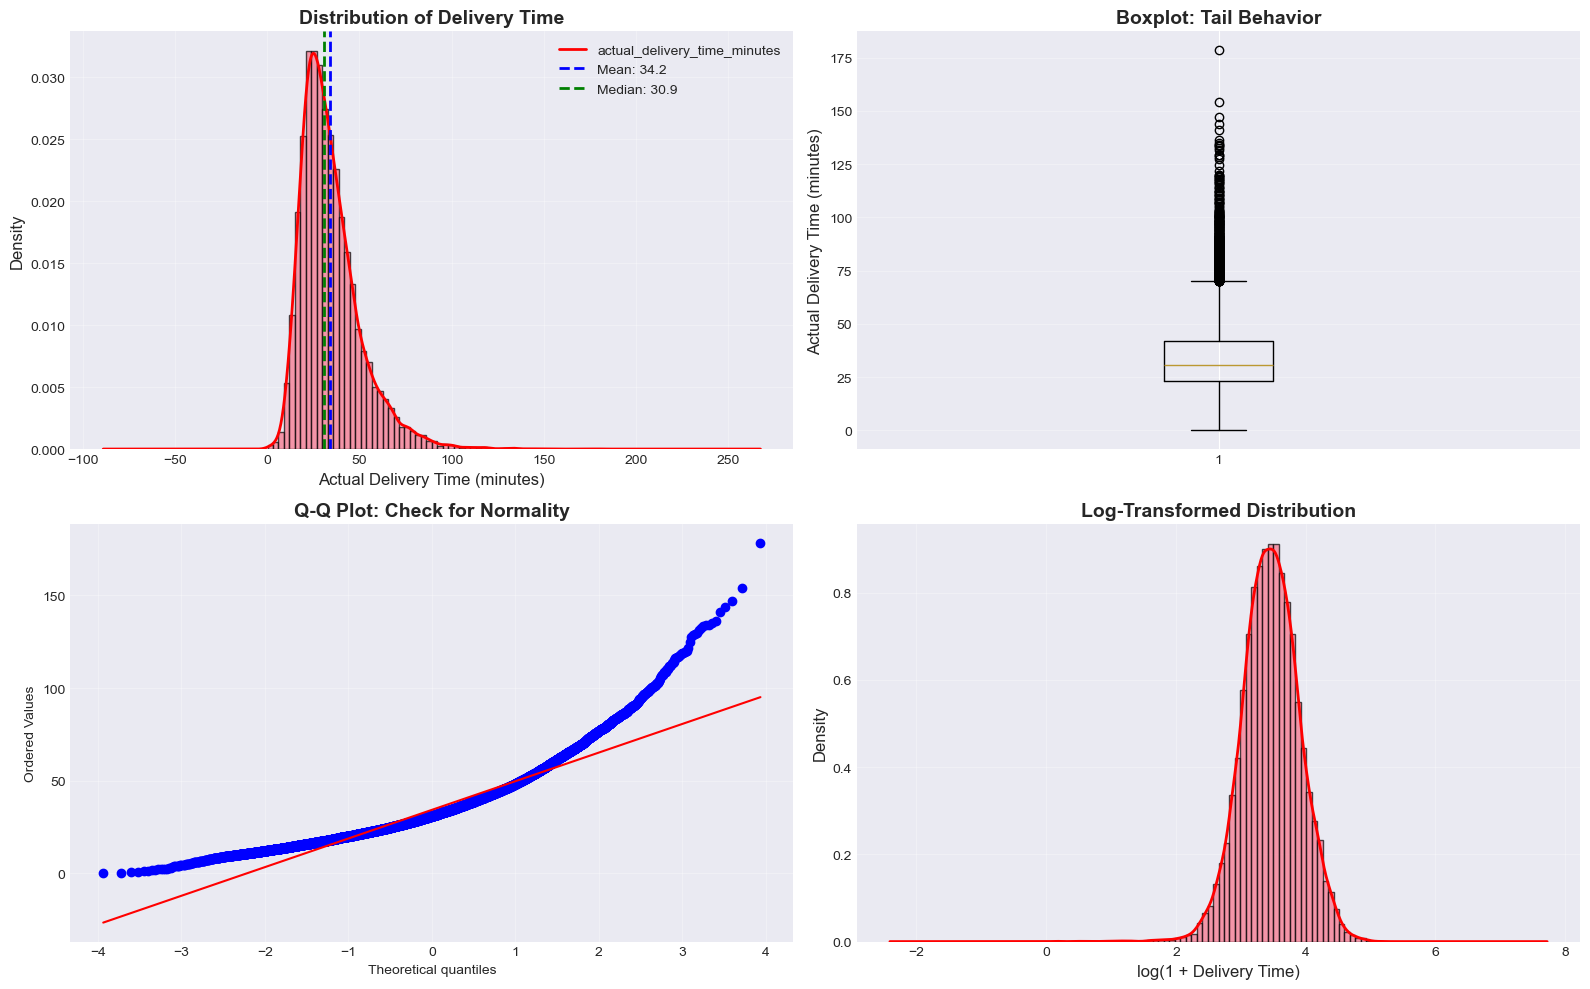

In [31]:
# Visualize target distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram with KDE
axes[0, 0].hist(target, bins=60, edgecolor='black', alpha=0.7, density=True)
target.plot.kde(ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(target.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {target.mean():.1f}')
axes[0, 0].axvline(target.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {target.median():.1f}')
axes[0, 0].set_xlabel('Actual Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Distribution of Delivery Time', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Boxplot
axes[0, 1].boxplot(target, vert=True)
axes[0, 1].set_ylabel('Actual Delivery Time (minutes)', fontsize=12)
axes[0, 1].set_title('Boxplot: Tail Behavior', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Q-Q plot for normality
stats.probplot(target, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Check for Normality', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Log-transformed distribution
log_target = np.log1p(target)
axes[1, 1].hist(log_target, bins=60, edgecolor='black', alpha=0.7, density=True)
log_target.plot.kde(ax=axes[1, 1], color='red', linewidth=2)
axes[1, 1].set_xlabel('log(1 + Delivery Time)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
save_figure('01_target_distribution_overview.png')
plt.show()

### Interpretation: Section 1

**Key Observations:**
1. **Right-skewed distribution** (skewness > 0): Most deliveries complete quickly, with a long right tail
2. **Heavy tail behavior**: P95 and P99 show substantial tail mass
3. **Q-Q plot**: Deviates from normal distribution, especially in the tails
4. **Log transformation**: Improves symmetry, suggesting log-normal characteristics

**Modeling Implications:**
- Consider **quantile regression** to model the full conditional distribution
- Standard MSE loss may underweight tail predictions
- **Log-transformation** of target may improve performance for mean prediction
- Model should handle **heteroscedasticity** (varying variance)
- Separate models for mean vs uncertainty (P90, P95) may be beneficial

## Section 2: ETA Correspondence and Calibration

**Goal**: Assess whether current ETA estimates are well-calibrated and identify systematic bias.

In [32]:
# Create ETA-related features
df['estimate_width'] = df['estimated_delivery_time_upper_minutes'] - df['estimated_delivery_time_lower_minutes']
df['estimate_midpoint'] = (df['estimated_delivery_time_upper_minutes'] + df['estimated_delivery_time_lower_minutes']) / 2
df['residual'] = df['actual_delivery_time_minutes'] - df['estimate_midpoint']
df['late_flag'] = (df['actual_delivery_time_minutes'] > df['estimated_delivery_time_upper_minutes']).astype(int)
df['early_flag'] = (df['actual_delivery_time_minutes'] < df['estimated_delivery_time_lower_minutes']).astype(int)
df['within_estimate'] = ((df['actual_delivery_time_minutes'] >= df['estimated_delivery_time_lower_minutes']) & 
                          (df['actual_delivery_time_minutes'] <= df['estimated_delivery_time_upper_minutes'])).astype(int)

print("="*80)
print("ETA CALIBRATION ANALYSIS")
print("="*80)

print("\nEstimate Width Statistics:")
print(df['estimate_width'].describe())

print("\nResidual Statistics:")
print(df['residual'].describe())
print(f"Residual skewness: {df['residual'].skew():.3f}")
print(f"\nMean residual (bias): {df['residual'].mean():.3f} minutes")
print(f"Median residual: {df['residual'].median():.3f} minutes")
print(f"MAE: {np.abs(df['residual']).mean():.3f} minutes")
print(f"RMSE: {np.sqrt((df['residual']**2).mean()):.3f} minutes")

print("\nCalibration Metrics:")
print(f"Late delivery rate: {df['late_flag'].mean() * 100:.2f}%")
print(f"Early delivery rate: {df['early_flag'].mean() * 100:.2f}%")
print(f"Coverage rate (within estimate): {df['within_estimate'].mean() * 100:.2f}%")

print(f"\nIdeal coverage would be close to target (e.g., 80% for 80% confidence interval)")
print(f"If late rate >> early rate, ETA is systematically optimistic")

ETA CALIBRATION ANALYSIS

Estimate Width Statistics:
count    16705.000
mean        10.126
std          1.562
min          5.000
25%         10.000
50%         10.000
75%         10.000
max         40.000
Name: estimate_width, dtype: float64

Residual Statistics:
count    16705.000
mean         2.511
std         13.442
min        -52.113
25%         -6.167
50%          0.832
75%          8.969
max        145.874
Name: residual, dtype: float64
Residual skewness: 1.379

Mean residual (bias): 2.511 minutes
Median residual: 0.832 minutes
MAE: 9.770 minutes
RMSE: 13.674 minutes

Calibration Metrics:
Late delivery rate: 35.83%
Early delivery rate: 28.47%
Coverage rate (within estimate): 35.70%

Ideal coverage would be close to target (e.g., 80% for 80% confidence interval)
If late rate >> early rate, ETA is systematically optimistic


✓ Saved figure: 02_eta_calibration_analysis.png


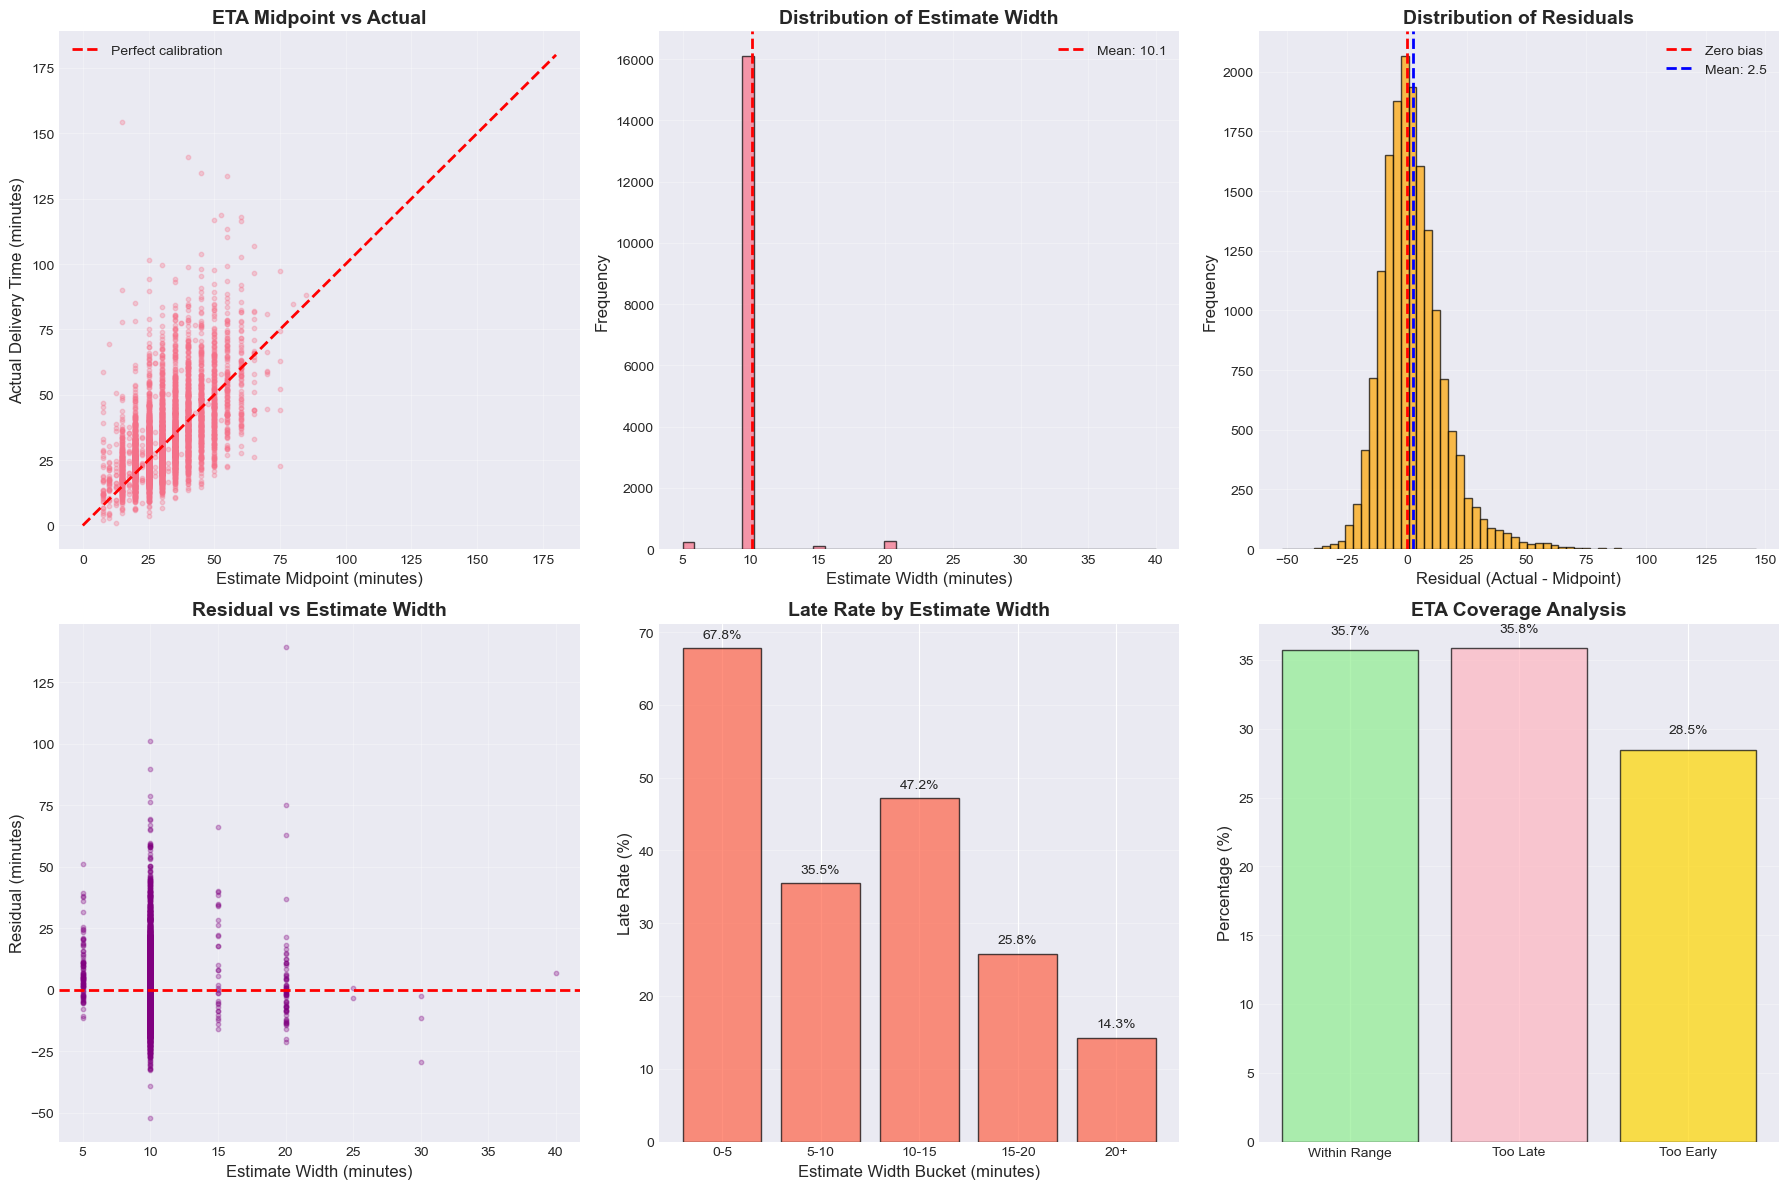

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatter: estimate midpoint vs actual
sample = df.sample(n=min(5000, len(df)), random_state=42)
axes[0, 0].scatter(sample['estimate_midpoint'], sample['actual_delivery_time_minutes'], 
                   alpha=0.3, s=10)
axes[0, 0].plot([0, 180], [0, 180], 'r--', linewidth=2, label='Perfect calibration')
axes[0, 0].set_xlabel('Estimate Midpoint (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Actual Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_title('ETA Midpoint vs Actual', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distribution of estimate width
axes[0, 1].hist(df['estimate_width'], bins=40, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['estimate_width'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["estimate_width"].mean():.1f}')
axes[0, 1].set_xlabel('Estimate Width (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Estimate Width', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution of residuals
axes[0, 2].hist(df['residual'], bins=60, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero bias')
axes[0, 2].axvline(df['residual'].mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["residual"].mean():.1f}')
axes[0, 2].set_xlabel('Residual (Actual - Midpoint)', fontsize=12)
axes[0, 2].set_ylabel('Frequency', fontsize=12)
axes[0, 2].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Residual vs estimate width
axes[1, 0].scatter(sample['estimate_width'], sample['residual'], alpha=0.3, s=10, color='purple')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Estimate Width (minutes)', fontsize=12)
axes[1, 0].set_ylabel('Residual (minutes)', fontsize=12)
axes[1, 0].set_title('Residual vs Estimate Width', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Late rate by estimate width bucket
df['width_bucket'] = pd.cut(df['estimate_width'], bins=[0, 5, 10, 15, 20, 100], 
                              labels=['0-5', '5-10', '10-15', '15-20', '20+'])
late_by_width = df.groupby('width_bucket', observed=True)['late_flag'].mean() * 100
axes[1, 1].bar(range(len(late_by_width)), late_by_width.values, edgecolor='black', alpha=0.7, color='tomato')
axes[1, 1].set_xticks(range(len(late_by_width)))
axes[1, 1].set_xticklabels(late_by_width.index)
axes[1, 1].set_xlabel('Estimate Width Bucket (minutes)', fontsize=12)
axes[1, 1].set_ylabel('Late Rate (%)', fontsize=12)
axes[1, 1].set_title('Late Rate by Estimate Width', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(late_by_width.values):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Coverage analysis
coverage_data = pd.DataFrame({
    'Category': ['Within Range', 'Too Late', 'Too Early'],
    'Count': [df['within_estimate'].sum(), df['late_flag'].sum(), df['early_flag'].sum()]
})
coverage_data['Percentage'] = coverage_data['Count'] / len(df) * 100
axes[1, 2].bar(coverage_data['Category'], coverage_data['Percentage'], 
               edgecolor='black', alpha=0.7, color=['#90EE90', '#FFB6C1', '#FFD700'])
axes[1, 2].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 2].set_title('ETA Coverage Analysis', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, (cat, pct) in enumerate(zip(coverage_data['Category'], coverage_data['Percentage'])):
    axes[1, 2].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
save_figure('02_eta_calibration_analysis.png')
plt.show()

### Interpretation: Section 2

**Key Findings:**
1. **Systematic bias**: If mean residual ≠ 0, ETA is consistently over/under-estimating
2. **Calibration**: Coverage rate indicates whether interval width matches actual uncertainty
3. **Width-uncertainty relationship**: Check if larger intervals correlate with higher late rates
4. **Asymmetry**: Compare late vs early rates to detect directional bias

**Modeling Implications:**
- If bias exists, consider **bias correction** in current ETA
- **Residual modeling** can improve on existing estimates
- Larger estimate_width should be a strong signal of uncertainty
- **Quantile models** can directly optimize for coverage
- Current ETA features should be included as they contain domain knowledge

## Section 3: Temporal Patterns

**Goal**: Identify time-of-day and day-of-week effects on delivery time and variability.

In [ ]:
df['hour'] = df['order_placed_at_utc'].dt.hour
df['day_of_week'] = df['order_placed_at_utc'].dt.dayofweek
df['day_name'] = df['order_placed_at_utc'].dt.day_name()
df['weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month'] = df['order_placed_at_utc'].dt.month

print("="*80)
print("TEMPORAL PATTERNS ANALYSIS")
print("="*80)

hourly_stats = df.groupby('hour').agg({
    'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9)],
    'late_flag': 'mean',
    'order_placed_at_utc': 'count',
    'courier_supply_index': 'mean'
}).round(2)
hourly_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'Late_Rate', 'Order_Count', 'Avg_Supply']
hourly_stats['Late_Rate'] = (hourly_stats['Late_Rate'] * 100).round(1)

print("\nHourly Statistics:")
print(hourly_stats.to_string())

peak_orders = hourly_stats['Order_Count'].idxmax()
peak_time = hourly_stats['Avg_Time'].idxmax()
peak_late = hourly_stats['Late_Rate'].idxmax()

print(f"\nPeak order volume: Hour {peak_orders} ({hourly_stats.loc[peak_orders, 'Order_Count']:.0f} orders)")
print(f"Longest delivery times: Hour {peak_time} ({hourly_stats.loc[peak_time, 'Avg_Time']:.1f} min avg)")
print(f"Highest late rate: Hour {peak_late} ({hourly_stats.loc[peak_late, 'Late_Rate']:.1f}%)")

TEMPORAL PATTERNS ANALYSIS

Hourly Statistics:
      Avg_Time  Std_Time  P90_Time  Late_Rate  Order_Count  Avg_Supply
hour                                                                  
4        22.88      5.22     26.76        0.0            3        1.56
5        29.70      8.27     39.21       31.0           32        1.59
6        31.68     14.46     51.88       37.0          123        1.56
7        29.58     14.18     45.80       35.0          342        1.62
8        30.56     14.35     48.51       30.0          861        1.76
9        36.81     17.24     60.39       40.0         1798        1.77
10       35.51     15.93     57.46       38.0         1462        1.66
11       31.96     14.82     49.95       35.0         1096        1.57
12       33.31     15.50     52.82       40.0         1018        1.58
13       33.38     15.81     51.54       34.0         1095        1.69
14       33.61     16.29     53.61       32.0         1440        1.89
15       34.98     17.12     5

In [35]:
# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = df.groupby('day_name').agg({
    'actual_delivery_time_minutes': ['mean', 'std'],
    'late_flag': 'mean',
    'order_placed_at_utc': 'count'
}).round(2)
dow_stats.columns = ['Avg_Time', 'Std_Time', 'Late_Rate', 'Order_Count']
dow_stats['Late_Rate'] = (dow_stats['Late_Rate'] * 100).round(1)
dow_stats = dow_stats.reindex(day_order)

print("\nDay of Week Statistics:")
print(dow_stats.to_string())

# Weekend vs weekday
weekend_comparison = df.groupby('weekend').agg({
    'actual_delivery_time_minutes': ['mean', 'std'],
    'late_flag': 'mean'
}).round(2)
weekend_comparison.index = ['Weekday', 'Weekend']
weekend_comparison.columns = ['Avg_Time', 'Std_Time', 'Late_Rate']
weekend_comparison['Late_Rate'] = (weekend_comparison['Late_Rate'] * 100).round(1)

print("\nWeekend vs Weekday:")
print(weekend_comparison.to_string())


Day of Week Statistics:
           Avg_Time  Std_Time  Late_Rate  Order_Count
day_name                                             
Monday        34.29     16.54       34.0         1767
Tuesday       34.60     16.03       37.0         2238
Wednesday     32.15     13.98       33.0         2251
Thursday      32.41     14.37       32.0         2428
Friday        35.72     16.53       38.0         3150
Saturday      36.63     19.59       43.0         2523
Sunday        32.97     15.06       33.0         2348

Weekend vs Weekday:
         Avg_Time  Std_Time  Late_Rate
Weekday     33.94     15.61       35.0
Weekend     34.86     17.65       38.0


✓ Saved figure: 03_temporal_patterns_analysis.png


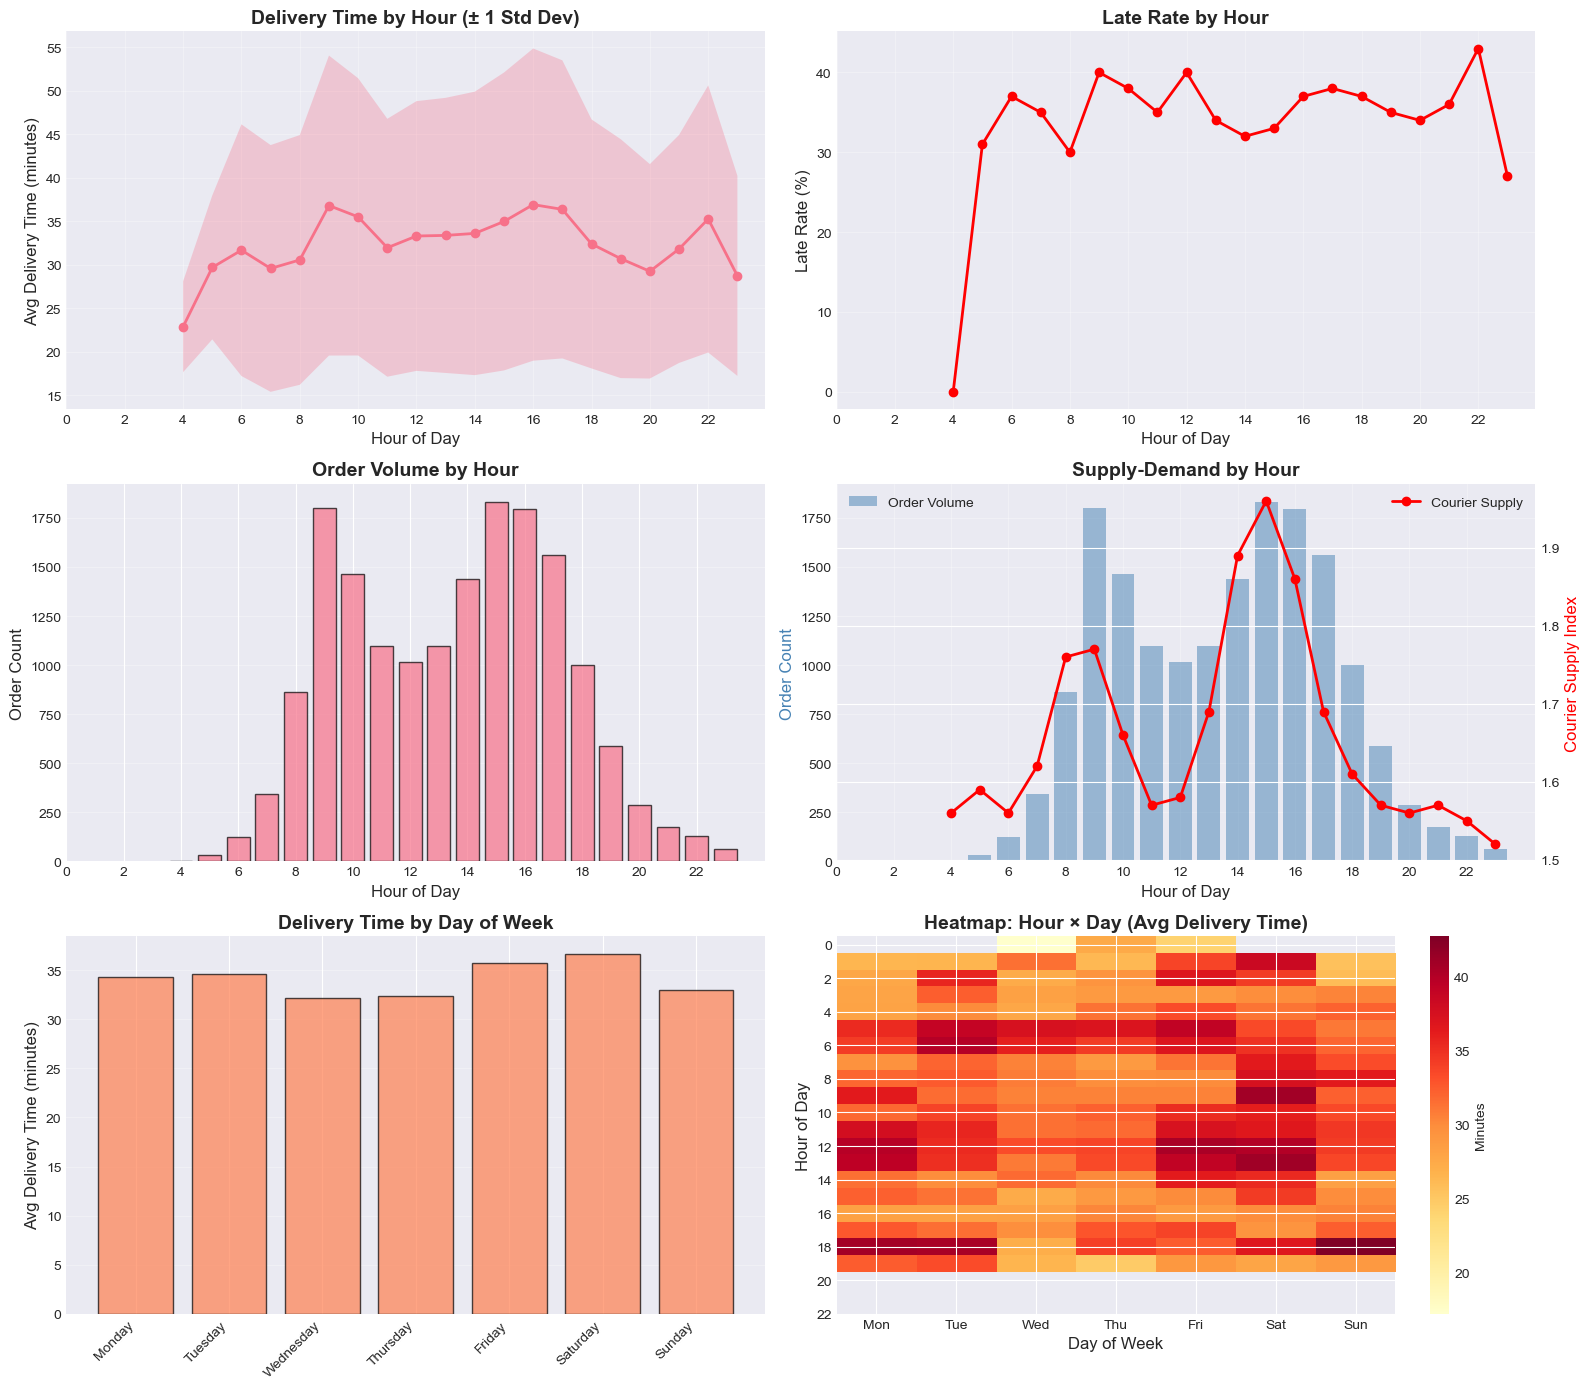

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Delivery time by hour
axes[0, 0].plot(hourly_stats.index, hourly_stats['Avg_Time'], marker='o', linewidth=2, markersize=6)
axes[0, 0].fill_between(hourly_stats.index, 
                         hourly_stats['Avg_Time'] - hourly_stats['Std_Time'],
                         hourly_stats['Avg_Time'] + hourly_stats['Std_Time'],
                         alpha=0.3)
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_title('Delivery Time by Hour (± 1 Std Dev)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Late rate by hour
axes[0, 1].plot(hourly_stats.index, hourly_stats['Late_Rate'], marker='o', linewidth=2, 
                markersize=6, color='red')
axes[0, 1].set_xlabel('Hour of Day', fontsize=12)
axes[0, 1].set_ylabel('Late Rate (%)', fontsize=12)
axes[0, 1].set_title('Late Rate by Hour', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# Order volume by hour
axes[1, 0].bar(hourly_stats.index, hourly_stats['Order_Count'], edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Hour of Day', fontsize=12)
axes[1, 0].set_ylabel('Order Count', fontsize=12)
axes[1, 0].set_title('Order Volume by Hour', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(range(0, 24, 2))

# Supply vs demand by hour
ax1 = axes[1, 1]
ax2 = ax1.twinx()
ax1.bar(hourly_stats.index, hourly_stats['Order_Count'], alpha=0.5, label='Order Volume', color='steelblue')
ax2.plot(hourly_stats.index, hourly_stats['Avg_Supply'], marker='o', linewidth=2, 
         markersize=6, color='red', label='Courier Supply')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Order Count', fontsize=12, color='steelblue')
ax2.set_ylabel('Courier Supply Index', fontsize=12, color='red')
ax1.set_title('Supply-Demand by Hour', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Delivery time by day of week
axes[2, 0].bar(range(7), dow_stats['Avg_Time'], edgecolor='black', alpha=0.7, color='coral')
axes[2, 0].set_xticks(range(7))
axes[2, 0].set_xticklabels(day_order, rotation=45, ha='right')
axes[2, 0].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[2, 0].set_title('Delivery Time by Day of Week', fontsize=14, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3, axis='y')

# Heatmap: hour vs day of week
pivot_time = df.pivot_table(values='actual_delivery_time_minutes', 
                              index='hour', columns='day_of_week', aggfunc='mean')
im = axes[2, 1].imshow(pivot_time.values, cmap='YlOrRd', aspect='auto')
axes[2, 1].set_yticks(range(0, 24, 2))
axes[2, 1].set_yticklabels(range(0, 24, 2))
axes[2, 1].set_xticks(range(7))
axes[2, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[2, 1].set_ylabel('Hour of Day', fontsize=12)
axes[2, 1].set_xlabel('Day of Week', fontsize=12)
axes[2, 1].set_title('Heatmap: Hour × Day (Avg Delivery Time)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[2, 1], label='Minutes')

plt.tight_layout()
save_figure('03_temporal_patterns_analysis.png')
plt.show()

### Interpretation: Section 3

**Key Findings:**
1. **Peak hour effects**: Identify hours with longest delivery times and highest late rates
2. **Supply-demand mismatch**: Compare order volume vs courier supply to detect capacity constraints
3. **Temporal heteroscedasticity**: Standard deviation varies by time, indicating uncertainty is time-dependent
4. **Day-of-week patterns**: Weekend vs weekday differences in volume and performance

**Modeling Implications:**
- **Hour and day features** are strong predictors
- Consider **cyclical encoding** (sin/cos) for hour to capture periodicity
- **Time-of-day interactions** with other features (supply, weather) likely important
- Variance changes with time → **heteroscedastic models** needed
- Peak hours may benefit from **separate model calibration**

## Section 4: Weather Effects

**Goal**: Quantify precipitation impact on delivery time mean, variance, and tail behavior.

In [37]:
# Create precipitation buckets
df['precip_category'] = pd.cut(df['precipitation'], 
                                bins=[-0.1, 0.001, 2, 5, 100],
                                labels=['None (0)', 'Light (0-2mm)', 'Moderate (2-5mm)', 'Heavy (5+mm)'])

print("="*80)
print("WEATHER EFFECTS ANALYSIS")
print("="*80)

precip_stats = df.groupby('precip_category', observed=True).agg({
    'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9), lambda x: x.quantile(0.95)],
    'late_flag': 'mean',
    'estimate_width': 'mean',
    'order_placed_at_utc': 'count'
}).round(2)
precip_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'P95_Time', 'Late_Rate', 'Avg_Width', 'Order_Count']
precip_stats['Late_Rate'] = (precip_stats['Late_Rate'] * 100).round(1)

print("\nPrecipitation Impact:")
print(precip_stats.to_string())

# Calculate lift from no precipitation
baseline = precip_stats.loc['None (0)', 'Avg_Time']
print(f"\nBaseline (no precipitation): {baseline:.2f} minutes")
for cat in precip_stats.index[1:]:
    lift = precip_stats.loc[cat, 'Avg_Time'] - baseline
    lift_pct = (lift / baseline) * 100
    print(f"{cat}: +{lift:.2f} min (+{lift_pct:.1f}%)")

WEATHER EFFECTS ANALYSIS

Precipitation Impact:
                  Avg_Time  Std_Time  P90_Time  P95_Time  Late_Rate  Avg_Width  Order_Count
precip_category                                                                            
None (0)             33.86     15.92     54.34     64.31       35.0      10.13        14139
Light (0-2mm)        36.36     17.91     61.21     73.26       41.0      10.13         2445
Moderate (2-5mm)     31.21     13.48     49.00     55.38       31.0      10.00          121

Baseline (no precipitation): 33.86 minutes
Light (0-2mm): +2.50 min (+7.4%)
Moderate (2-5mm): +-2.65 min (+-7.8%)


✓ Saved figure: 04_weather_effects_analysis.png


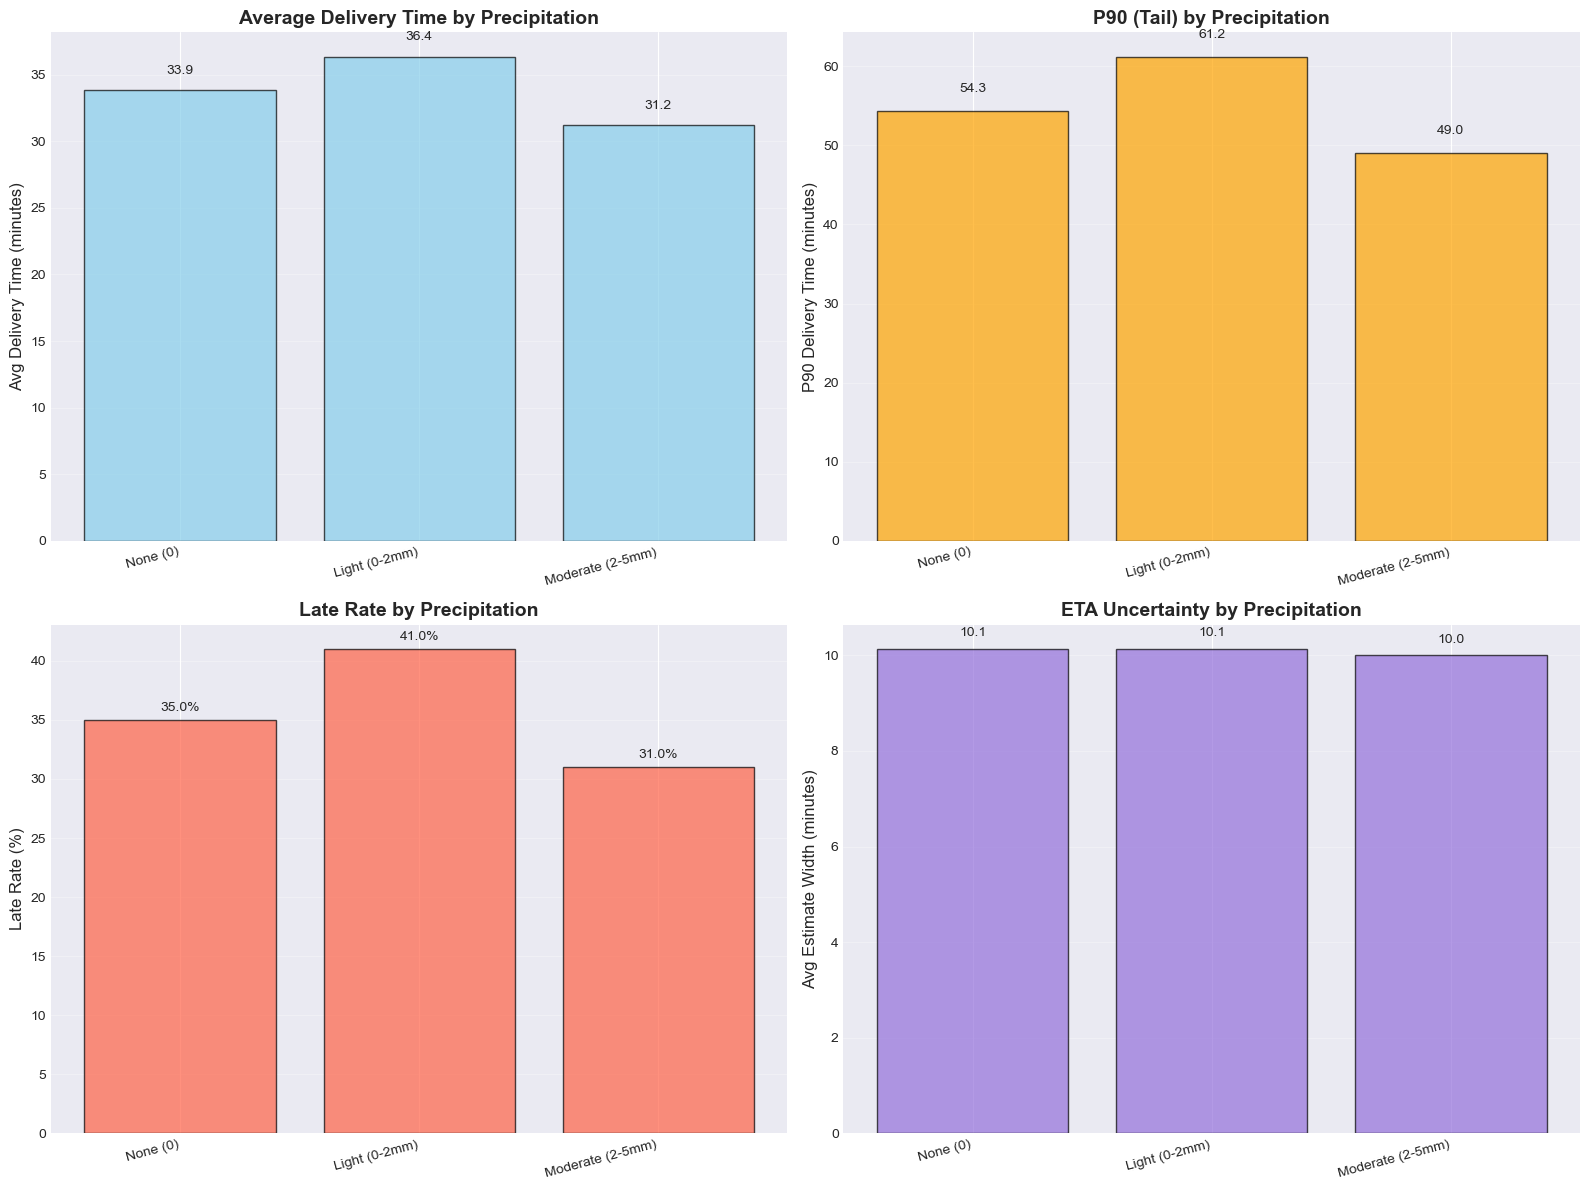

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average delivery time by precipitation
cats = precip_stats.index
axes[0, 0].bar(range(len(cats)), precip_stats['Avg_Time'], edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xticks(range(len(cats)))
axes[0, 0].set_xticklabels(cats, rotation=15, ha='right')
axes[0, 0].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_title('Average Delivery Time by Precipitation', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precip_stats['Avg_Time']):
    axes[0, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# P90 delivery time by precipitation
axes[0, 1].bar(range(len(cats)), precip_stats['P90_Time'], edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xticks(range(len(cats)))
axes[0, 1].set_xticklabels(cats, rotation=15, ha='right')
axes[0, 1].set_ylabel('P90 Delivery Time (minutes)', fontsize=12)
axes[0, 1].set_title('P90 (Tail) by Precipitation', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precip_stats['P90_Time']):
    axes[0, 1].text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# Late rate by precipitation
axes[1, 0].bar(range(len(cats)), precip_stats['Late_Rate'], edgecolor='black', alpha=0.7, color='tomato')
axes[1, 0].set_xticks(range(len(cats)))
axes[1, 0].set_xticklabels(cats, rotation=15, ha='right')
axes[1, 0].set_ylabel('Late Rate (%)', fontsize=12)
axes[1, 0].set_title('Late Rate by Precipitation', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precip_stats['Late_Rate']):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Estimate width by precipitation
axes[1, 1].bar(range(len(cats)), precip_stats['Avg_Width'], edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1, 1].set_xticks(range(len(cats)))
axes[1, 1].set_xticklabels(cats, rotation=15, ha='right')
axes[1, 1].set_ylabel('Avg Estimate Width (minutes)', fontsize=12)
axes[1, 1].set_title('ETA Uncertainty by Precipitation', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precip_stats['Avg_Width']):
    axes[1, 1].text(i, v + 0.2, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
save_figure('04_weather_effects_analysis.png')
plt.show()

### Interpretation: Section 4

**Key Findings:**
1. **Mean vs tail impact**: Does precipitation affect only average or also increase tail?
2. **ETA adaptation**: Does estimate_width increase during rain? (Shows if ETA system accounts for weather)
3. **Late rate increase**: Quantifies underestimation during bad weather
4. **Magnitude**: What % increase in delivery time per mm of precipitation?

**Modeling Implications:**
- **Precipitation is predictive** if clear differences exist
- Consider **interaction terms** (e.g., rain × peak hour, rain × distance)
- If tail expands more than mean, use **quantile regression** for robust predictions
- **Threshold effects**: Light vs heavy rain may need separate treatment
- If ETA doesn't widen enough during rain, model should correct this

## Section 5: Courier Supply Effects

**Goal**: Understand how courier availability affects delivery time and variance.

In [39]:
# Create supply quartiles
df['supply_quartile'] = pd.qcut(df['courier_supply_index'], q=4, 
                                  labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'],
                                  duplicates='drop')

print("="*80)
print("COURIER SUPPLY EFFECTS")
print("="*80)

supply_stats = df.groupby('supply_quartile', observed=True).agg({
    'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9)],
    'late_flag': 'mean',
    'order_placed_at_utc': 'count',
    'courier_supply_index': ['min', 'max']
}).round(2)
supply_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'Late_Rate', 'Order_Count', 'Supply_Min', 'Supply_Max']
supply_stats['Late_Rate'] = (supply_stats['Late_Rate'] * 100).round(1)

print("\nSupply Quartile Analysis:")
print(supply_stats.to_string())

# Calculate impact
low_supply = supply_stats.loc['Q1 (Lowest)', 'Avg_Time']
high_supply = supply_stats.loc['Q4 (Highest)', 'Avg_Time']
print(f"\nDelivery time difference: Low supply vs High supply = {low_supply - high_supply:.2f} minutes")

COURIER SUPPLY EFFECTS

Supply Quartile Analysis:
                 Avg_Time  Std_Time  P90_Time  Late_Rate  Order_Count  Supply_Min  Supply_Max
supply_quartile                                                                              
Q1 (Lowest)         34.97     15.29     53.87       43.0         4265        1.00        1.56
Q2                  34.88     16.79     56.49       38.0         4160        1.57        1.73
Q3                  33.48     16.16     55.28       32.0         4286        1.74        1.90
Q4 (Highest)        33.47     16.65     55.64       30.0         3994        1.91        2.64

Delivery time difference: Low supply vs High supply = 1.50 minutes


In [40]:
# Interaction: supply × precipitation
interaction = df.groupby(['supply_quartile', 'precip_category'], observed=True).agg({
    'actual_delivery_time_minutes': 'mean',
    'late_flag': 'mean',
    'order_placed_at_utc': 'count'
}).round(2)
interaction.columns = ['Avg_Time', 'Late_Rate', 'Count']
interaction['Late_Rate'] = (interaction['Late_Rate'] * 100).round(1)
interaction = interaction[interaction['Count'] >= 20]  # Filter small samples

print("\nSupply × Precipitation Interaction:")
print(interaction.to_string())


Supply × Precipitation Interaction:
                                  Avg_Time  Late_Rate  Count
supply_quartile precip_category                             
Q1 (Lowest)     None (0)             34.63       41.0   3539
                Light (0-2mm)        36.77       49.0    703
                Moderate (2-5mm)     32.85       39.0     23
Q2              None (0)             34.44       38.0   3552
                Light (0-2mm)        37.66       43.0    596
Q3              None (0)             32.86       31.0   3666
                Light (0-2mm)        37.54       40.0    564
                Moderate (2-5mm)     32.79       38.0     56
Q4 (Highest)    None (0)             33.53       30.0   3382
                Light (0-2mm)        33.39       31.0    582
                Moderate (2-5mm)     28.28       17.0     30


✓ Saved figure: 05_courier_supply_effects.png


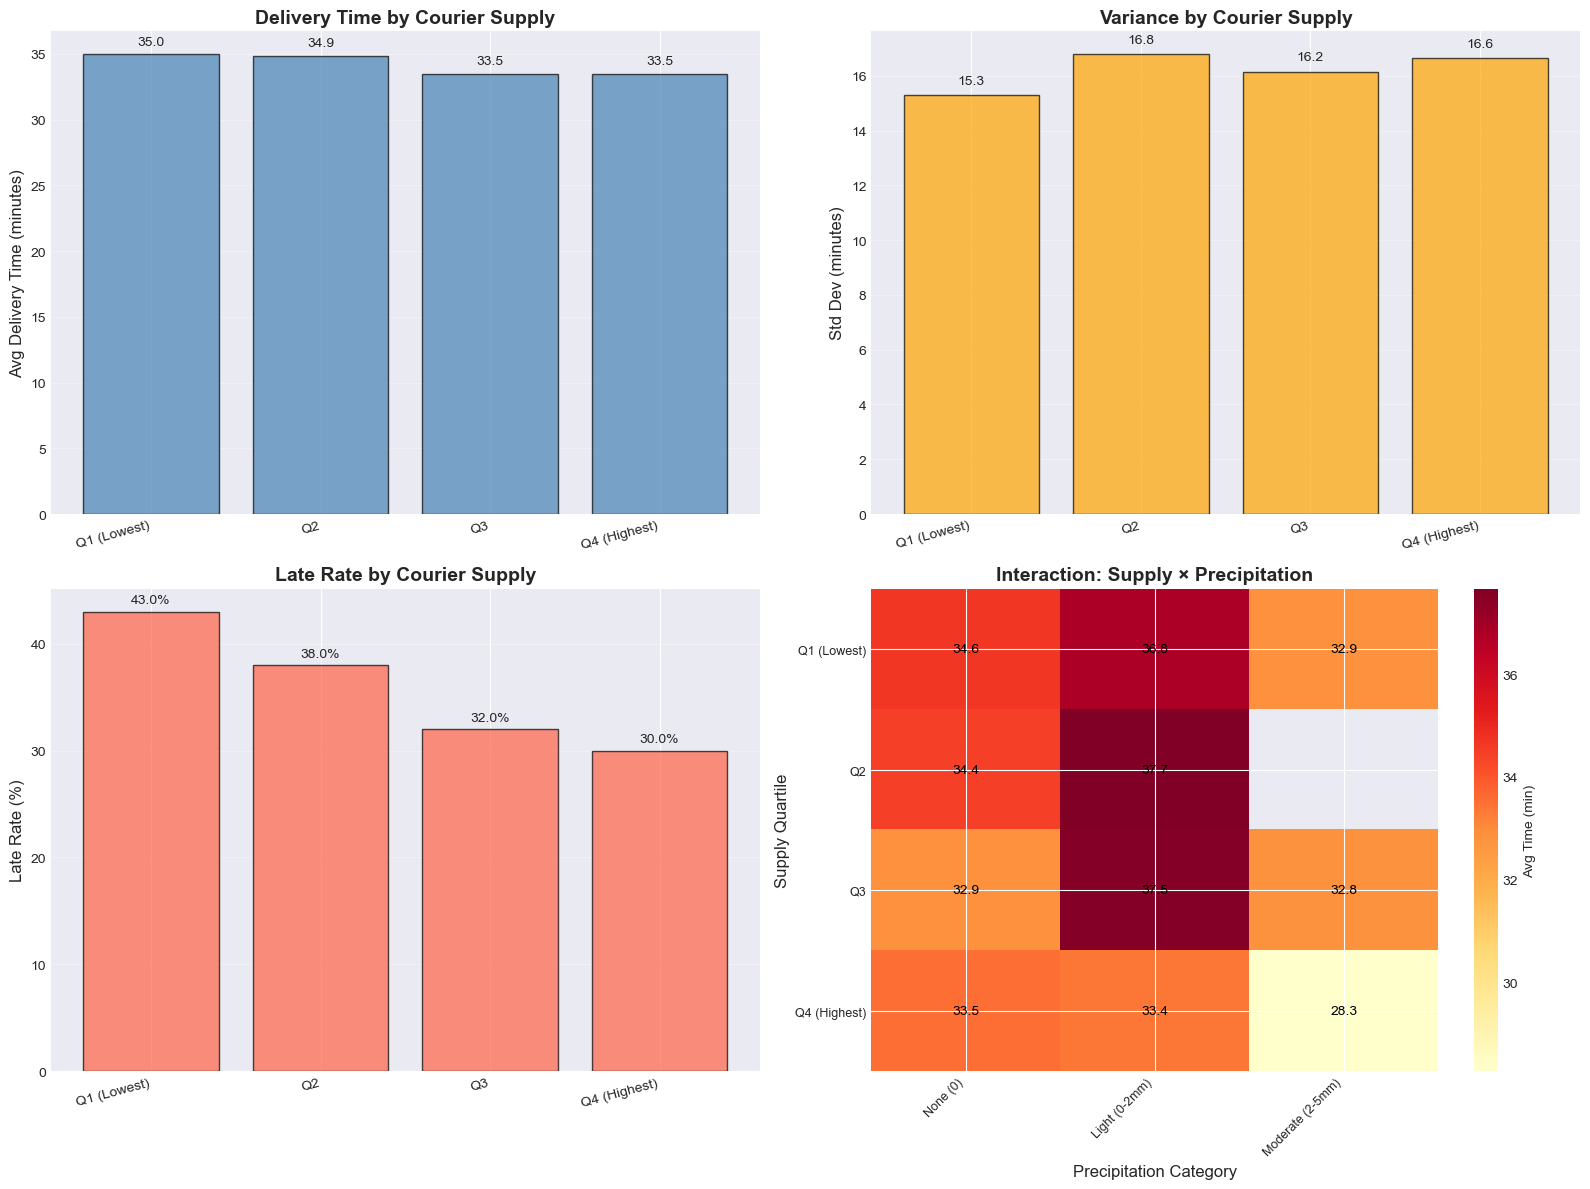

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average delivery time by supply
quarts = supply_stats.index
axes[0, 0].bar(range(len(quarts)), supply_stats['Avg_Time'], edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xticks(range(len(quarts)))
axes[0, 0].set_xticklabels(quarts, rotation=15, ha='right')
axes[0, 0].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_title('Delivery Time by Courier Supply', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(supply_stats['Avg_Time']):
    axes[0, 0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# Standard deviation by supply (variance analysis)
axes[0, 1].bar(range(len(quarts)), supply_stats['Std_Time'], edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xticks(range(len(quarts)))
axes[0, 1].set_xticklabels(quarts, rotation=15, ha='right')
axes[0, 1].set_ylabel('Std Dev (minutes)', fontsize=12)
axes[0, 1].set_title('Variance by Courier Supply', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(supply_stats['Std_Time']):
    axes[0, 1].text(i, v + 0.3, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# Late rate by supply
axes[1, 0].bar(range(len(quarts)), supply_stats['Late_Rate'], edgecolor='black', alpha=0.7, color='tomato')
axes[1, 0].set_xticks(range(len(quarts)))
axes[1, 0].set_xticklabels(quarts, rotation=15, ha='right')
axes[1, 0].set_ylabel('Late Rate (%)', fontsize=12)
axes[1, 0].set_title('Late Rate by Courier Supply', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(supply_stats['Late_Rate']):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Interaction heatmap: supply × precipitation
if len(interaction) > 0:
    pivot_interact = interaction['Avg_Time'].unstack(fill_value=np.nan)
    im = axes[1, 1].imshow(pivot_interact.values, cmap='YlOrRd', aspect='auto')
    axes[1, 1].set_yticks(range(len(pivot_interact.index)))
    axes[1, 1].set_yticklabels(pivot_interact.index, fontsize=9)
    axes[1, 1].set_xticks(range(len(pivot_interact.columns)))
    axes[1, 1].set_xticklabels(pivot_interact.columns, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_ylabel('Supply Quartile', fontsize=12)
    axes[1, 1].set_xlabel('Precipitation Category', fontsize=12)
    axes[1, 1].set_title('Interaction: Supply × Precipitation', fontsize=14, fontweight='bold')
    for i in range(len(pivot_interact.index)):
        for j in range(len(pivot_interact.columns)):
            val = pivot_interact.values[i, j]
            if not np.isnan(val):
                axes[1, 1].text(j, i, f'{val:.1f}', ha='center', va='center', 
                                color='white' if val > 50 else 'black', fontsize=10)
    plt.colorbar(im, ax=axes[1, 1], label='Avg Time (min)')

plt.tight_layout()
save_figure('05_courier_supply_effects.png')
plt.show()

### Interpretation: Section 5

**Key Findings:**
1. **Supply-time relationship**: Does low supply increase mean delivery time?
2. **Variance impact**: Does low supply increase variance (heteroscedasticity)?
3. **Interaction effects**: Is impact of rain worse when supply is low?
4. **Late rate sensitivity**: How much more likely are late deliveries with low supply?

**Modeling Implications:**
- **Courier supply index is a strong predictor**
- **Interaction terms recommended**: supply × precipitation, supply × hour
- Low supply increases both mean AND variance → **quantile models** capture full distribution
- Supply could be **non-linear** (threshold effects at very low supply)
- Real-time supply updates would improve predictions

## Section 6: Item Count and Category Effects

**Goal**: Assess whether order size and type significantly affect delivery time.

In [42]:
print("="*80)
print("ITEM COUNT AND CATEGORY EFFECTS")
print("="*80)

# Correlation
corr_pearson = df['item_count'].corr(df['actual_delivery_time_minutes'])
corr_spearman = df['item_count'].corr(df['actual_delivery_time_minutes'], method='spearman')

print(f"\nCorrelation: item_count vs delivery_time")
print(f"Pearson:  {corr_pearson:.4f}")
print(f"Spearman: {corr_spearman:.4f}")

# Item count buckets
df['item_bucket'] = pd.cut(df['item_count'], bins=[0, 2, 5, 10, 100],
                             labels=['1-2', '3-5', '6-10', '10+'])

item_stats = df.groupby('item_bucket', observed=True).agg({
    'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9)],
    'late_flag': 'mean',
    'order_placed_at_utc': 'count'
}).round(2)
item_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'Late_Rate', 'Order_Count']
item_stats['Late_Rate'] = (item_stats['Late_Rate'] * 100).round(1)

print("\nDelivery Statistics by Item Count:")
print(item_stats.to_string())

# Category analysis
category_stats = df.groupby('order_category', observed=True).agg({
    'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9)],
    'late_flag': 'mean',
    'order_placed_at_utc': 'count',
    'item_count': 'mean'
}).round(2)
category_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'Late_Rate', 'Order_Count', 'Avg_Items']
category_stats['Late_Rate'] = (category_stats['Late_Rate'] * 100).round(1)

print("\nDelivery Statistics by Order Category:")
print(category_stats.to_string())

ITEM COUNT AND CATEGORY EFFECTS

Correlation: item_count vs delivery_time
Pearson:  0.0538
Spearman: 0.0936

Delivery Statistics by Item Count:
             Avg_Time  Std_Time  P90_Time  Late_Rate  Order_Count
item_bucket                                                      
1-2             33.26     15.99     53.51       36.0        10117
3-5             35.91     15.95     57.10       38.0         4433
6-10            34.55     17.33     58.07       33.0         1177
10+             35.89     17.83     59.76       33.0          978

Delivery Statistics by Order Category:
                Avg_Time  Std_Time  P90_Time  Late_Rate  Order_Count  Avg_Items
order_category                                                                 
Food delivery      34.59     16.11     55.28       37.0        14659       2.35
Retail             31.45     16.87     55.21       30.0         2046      11.96


✓ Saved figure: 06_item_count_category_effects.png


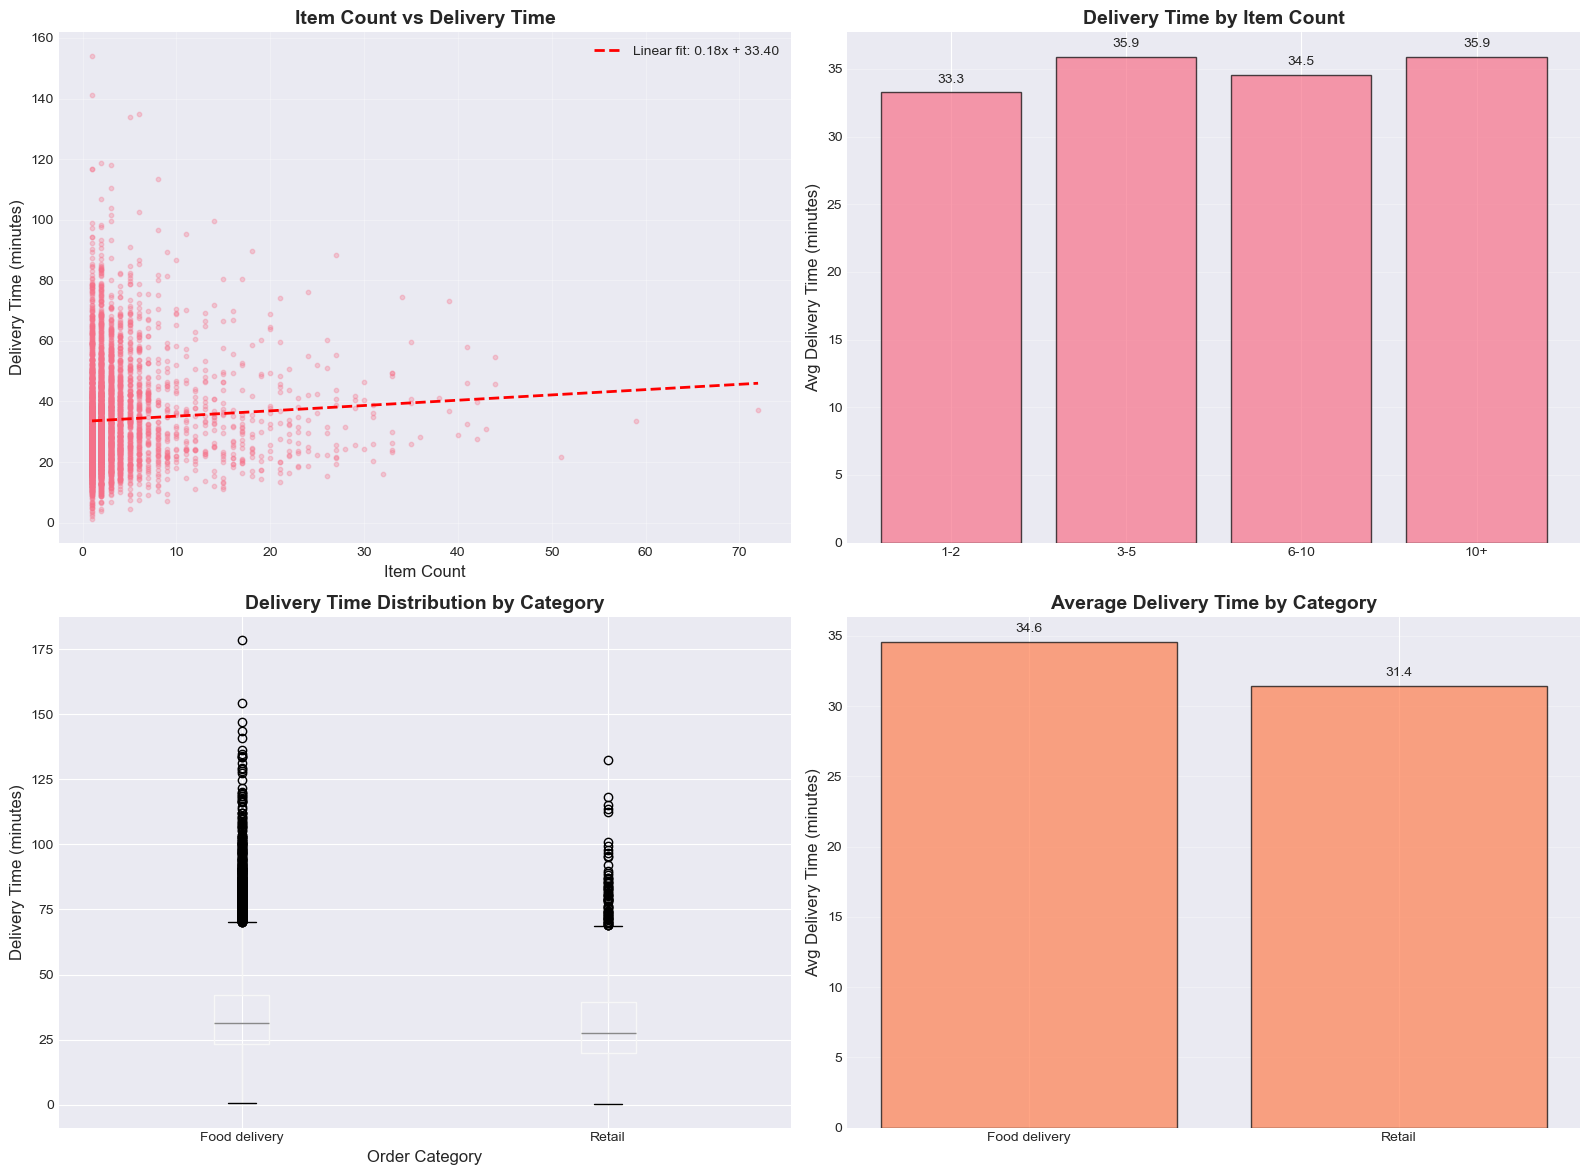

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter: item count vs delivery time
sample = df.sample(n=min(5000, len(df)), random_state=42)
axes[0, 0].scatter(sample['item_count'], sample['actual_delivery_time_minutes'], alpha=0.3, s=10)
# Add regression line
z = np.polyfit(sample['item_count'], sample['actual_delivery_time_minutes'], 1)
p = np.poly1d(z)
axes[0, 0].plot(sample['item_count'].sort_values(), p(sample['item_count'].sort_values()), 
                "r--", linewidth=2, label=f'Linear fit: {z[0]:.2f}x + {z[1]:.2f}')
axes[0, 0].set_xlabel('Item Count', fontsize=12)
axes[0, 0].set_ylabel('Delivery Time (minutes)', fontsize=12)
axes[0, 0].set_title('Item Count vs Delivery Time', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Delivery time by item bucket
buckets = item_stats.index
axes[0, 1].bar(range(len(buckets)), item_stats['Avg_Time'], edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(buckets)))
axes[0, 1].set_xticklabels(buckets)
axes[0, 1].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[0, 1].set_title('Delivery Time by Item Count', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(item_stats['Avg_Time']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# Boxplot by category
df.boxplot(column='actual_delivery_time_minutes', by='order_category', ax=axes[1, 0])
axes[1, 0].set_xlabel('Order Category', fontsize=12)
axes[1, 0].set_ylabel('Delivery Time (minutes)', fontsize=12)
axes[1, 0].set_title('Delivery Time Distribution by Category', fontsize=14, fontweight='bold')
axes[1, 0].get_figure().suptitle('')

# Category comparison
cats = category_stats.index
axes[1, 1].bar(range(len(cats)), category_stats['Avg_Time'], edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_xticks(range(len(cats)))
axes[1, 1].set_xticklabels(cats)
axes[1, 1].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
axes[1, 1].set_title('Average Delivery Time by Category', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(category_stats['Avg_Time']):
    axes[1, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
save_figure('06_item_count_category_effects.png')
plt.show()

### Interpretation: Section 6

**Key Findings:**
1. **Item count correlation**: Weak/moderate correlation suggests some predictive value
2. **Non-linear effects**: Relationship may plateau or have threshold effects
3. **Category differences**: Significant variation between food delivery, retail, etc.
4. **Confounding**: Category and item count may be correlated

**Modeling Implications:**
- **Item count** should be included as feature
- Consider **binning or spline transformations** for non-linearity
- **Order category** is categorical predictor (use one-hot encoding)
- **Category-specific models** might capture distinct dynamics
- Interactions: category × hour, category × supply

## Section 7: Spatial Analysis Using H3

**Goal**: Compute delivery distance and analyze spatial patterns in delivery time.

In [44]:
if H3_AVAILABLE:
    print("="*80)
    print("H3 SPATIAL ANALYSIS")
    print("="*80)
    
    # Compute H3 grid distance
    print("\nComputing H3 grid distances...")
    df['h3_distance'] = df.apply(
        lambda row: h3.grid_distance(
            row['venue_location_h3_index'], 
            row['customer_location_h3_index']
        ) if row['venue_location_h3_index'] != row['customer_location_h3_index'] else 0,
        axis=1
    )
    
    print(f"✓ H3 distance computed")
    print(f"\nH3 Distance Statistics:")
    print(df['h3_distance'].describe())
    print(f"Same location (distance=0): {(df['h3_distance'] == 0).sum():,} orders ({(df['h3_distance'] == 0).mean()*100:.1f}%)")
    
else:
    print("⚠️ H3 library not available. Spatial analysis skipped.")
    print("Install with: pip install h3")

H3 SPATIAL ANALYSIS

Computing H3 grid distances...
✓ H3 distance computed

H3 Distance Statistics:
count    16705.000
mean         1.825
std          1.805
min          0.000
25%          1.000
50%          1.000
75%          2.000
max         14.000
Name: h3_distance, dtype: float64
Same location (distance=0): 2,905 orders (17.4%)


In [45]:
if H3_AVAILABLE and 'h3_distance' in df.columns:
    # Create distance buckets
    df['distance_bucket'] = pd.cut(df['h3_distance'], 
                                     bins=[-1, 0, 2, 5, 10, 20, 100],
                                     labels=['0 (Same)', '1-2', '3-5', '6-10', '11-20', '20+'])
    
    distance_stats = df.groupby('distance_bucket', observed=True).agg({
        'actual_delivery_time_minutes': ['mean', 'std', lambda x: x.quantile(0.9)],
        'late_flag': 'mean',
        'order_placed_at_utc': 'count'
    }).round(2)
    distance_stats.columns = ['Avg_Time', 'Std_Time', 'P90_Time', 'Late_Rate', 'Order_Count']
    distance_stats['Late_Rate'] = (distance_stats['Late_Rate'] * 100).round(1)
    
    print("\nDelivery Statistics by H3 Distance:")
    print(distance_stats.to_string())
    
    # Correlation
    corr_distance = df['h3_distance'].corr(df['actual_delivery_time_minutes'])
    print(f"\nCorrelation (H3 distance vs delivery time): {corr_distance:.4f}")


Delivery Statistics by H3 Distance:
                 Avg_Time  Std_Time  P90_Time  Late_Rate  Order_Count
distance_bucket                                                      
0 (Same)            27.00     13.87     43.54       37.0         2905
1-2                 32.88     15.26     51.98       36.0        10048
3-5                 40.62     15.07     60.27       33.0         2833
6-10                51.72     17.96     74.12       36.0          910
11-20               52.11      9.68     63.04       56.0            9

Correlation (H3 distance vs delivery time): 0.3729


✓ Saved figure: 07_h3_spatial_distance_analysis.png


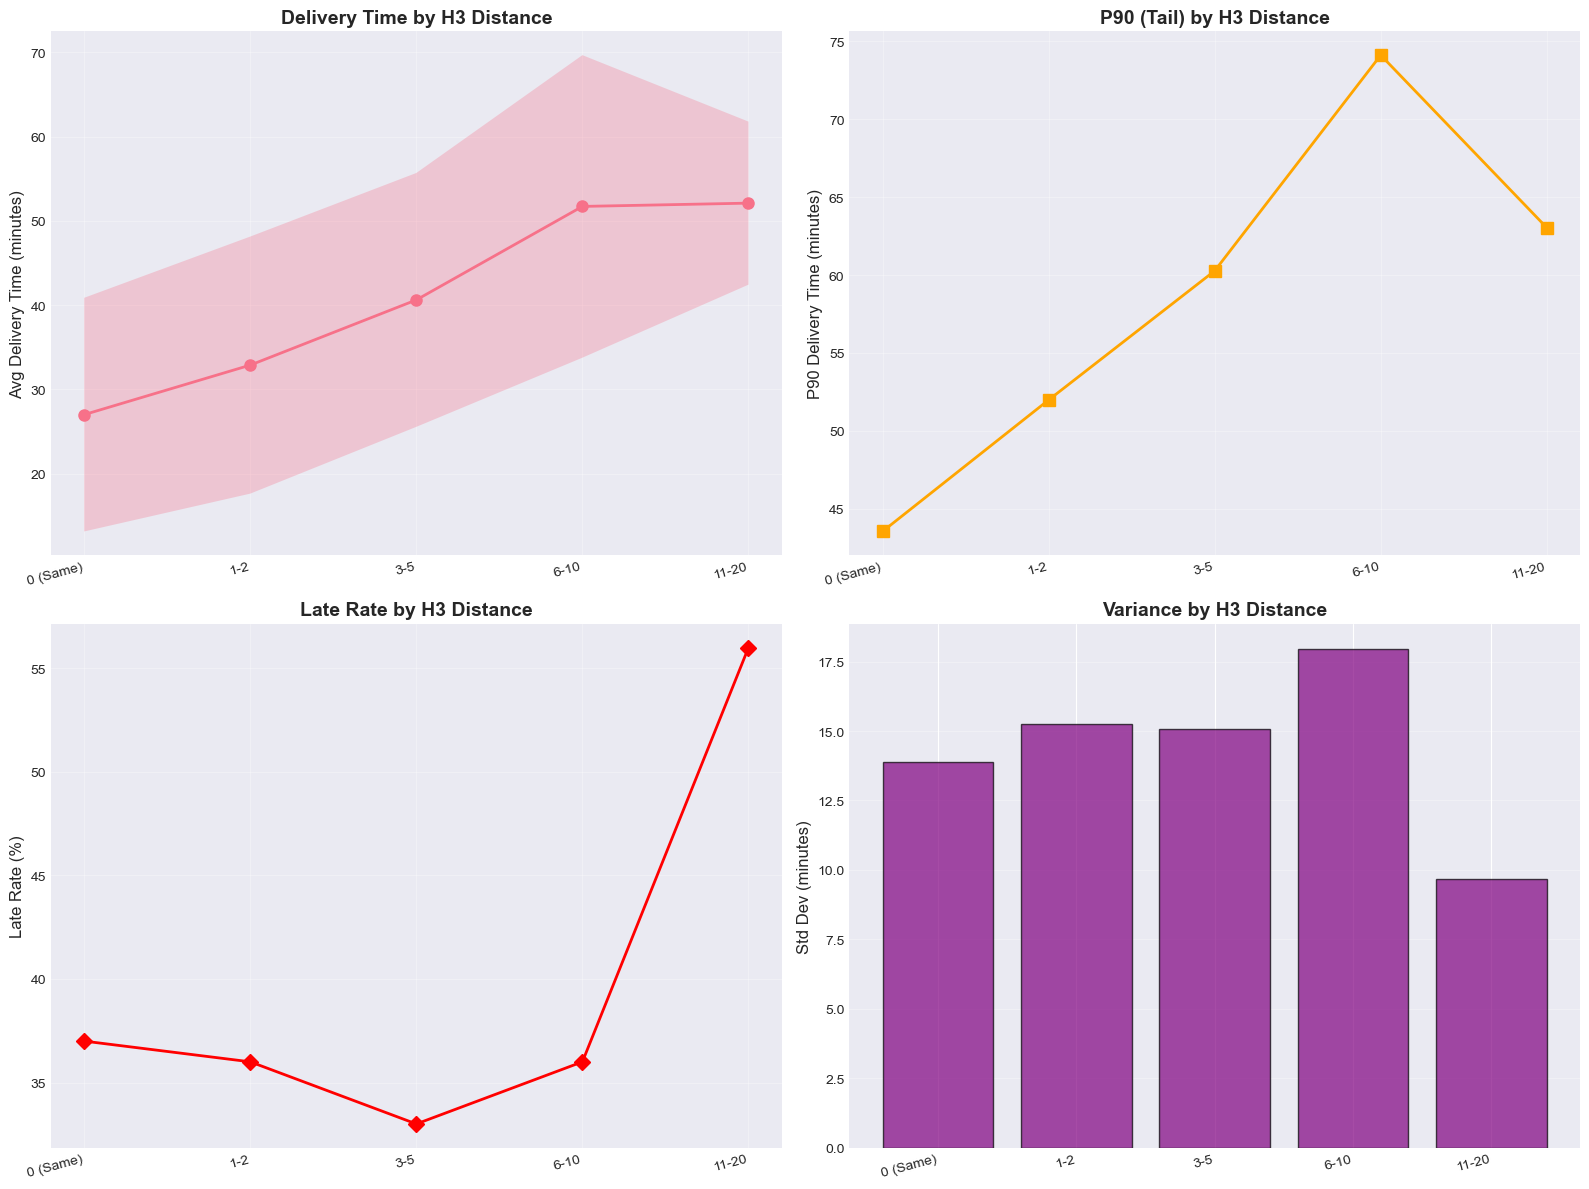

In [46]:
if H3_AVAILABLE and 'h3_distance' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Delivery time vs distance
    axes[0, 0].plot(distance_stats.index, distance_stats['Avg_Time'], marker='o', linewidth=2, markersize=8)
    axes[0, 0].fill_between(range(len(distance_stats)), 
                             distance_stats['Avg_Time'] - distance_stats['Std_Time'],
                             distance_stats['Avg_Time'] + distance_stats['Std_Time'],
                             alpha=0.3)
    axes[0, 0].set_xticks(range(len(distance_stats)))
    axes[0, 0].set_xticklabels(distance_stats.index, rotation=15, ha='right')
    axes[0, 0].set_ylabel('Avg Delivery Time (minutes)', fontsize=12)
    axes[0, 0].set_title('Delivery Time by H3 Distance', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # P90 by distance
    axes[0, 1].plot(distance_stats.index, distance_stats['P90_Time'], marker='s', 
                    linewidth=2, markersize=8, color='orange')
    axes[0, 1].set_xticks(range(len(distance_stats)))
    axes[0, 1].set_xticklabels(distance_stats.index, rotation=15, ha='right')
    axes[0, 1].set_ylabel('P90 Delivery Time (minutes)', fontsize=12)
    axes[0, 1].set_title('P90 (Tail) by H3 Distance', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Late rate by distance
    axes[1, 0].plot(distance_stats.index, distance_stats['Late_Rate'], marker='D', 
                    linewidth=2, markersize=8, color='red')
    axes[1, 0].set_xticks(range(len(distance_stats)))
    axes[1, 0].set_xticklabels(distance_stats.index, rotation=15, ha='right')
    axes[1, 0].set_ylabel('Late Rate (%)', fontsize=12)
    axes[1, 0].set_title('Late Rate by H3 Distance', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Variance (Std Dev) by distance
    axes[1, 1].bar(range(len(distance_stats)), distance_stats['Std_Time'], 
                   edgecolor='black', alpha=0.7, color='purple')
    axes[1, 1].set_xticks(range(len(distance_stats)))
    axes[1, 1].set_xticklabels(distance_stats.index, rotation=15, ha='right')
    axes[1, 1].set_ylabel('Std Dev (minutes)', fontsize=12)
    axes[1, 1].set_title('Variance by H3 Distance', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    save_figure('07_h3_spatial_distance_analysis.png')
    plt.show()

### Interpretation: Section 7

**Key Findings:**
1. **Monotonicity**: Is delivery time monotonically increasing with distance?
2. **Variance growth**: Does uncertainty increase with distance?
3. **Same-location orders**: Understand pick-up orders (distance=0)
4. **Non-linearity**: Check for saturation or threshold effects at long distances

**Modeling Implications:**
- **H3 distance is likely a strong predictor**
- Consider **polynomial or spline features** for non-linear relationship
- **Heteroscedasticity confirmed**: Variance increases with distance
- Same-location orders might need **separate handling**
- Alternative: Use lat/lon directly with distance calculation

## Section 10: Heteroscedasticity and Tail Behavior

**Goal**: Examine conditional variance to inform uncertainty modeling strategy.

In [49]:
print("="*80)
print("HETEROSCEDASTICITY ANALYSIS")
print("="*80)

# Variance by key dimensions
print("\nConditional Variance Analysis:\n")

# By supply quartile
print("Standard Deviation by Supply Quartile:")
supply_variance = df.groupby('supply_quartile', observed=True)['actual_delivery_time_minutes'].std()
print(supply_variance.to_string())
print(f"Variance ratio (Q1/Q4): {supply_variance.iloc[0] / supply_variance.iloc[-1]:.2f}")

if 'distance_bucket' in df.columns:
    print("\nStandard Deviation by Distance Bucket:")
    distance_variance = df.groupby('distance_bucket', observed=True)['actual_delivery_time_minutes'].std()
    print(distance_variance.to_string())

# By precipitation
print("\nStandard Deviation by Precipitation:")
precip_variance = df.groupby('precip_category', observed=True)['actual_delivery_time_minutes'].std()
print(precip_variance.to_string())

# By hour
print("\nStandard Deviation by Hour (peak hours):")
hour_variance = df.groupby('hour')['actual_delivery_time_minutes'].std().sort_values(ascending=False).head(5)
print(hour_variance.to_string())

HETEROSCEDASTICITY ANALYSIS

Conditional Variance Analysis:

Standard Deviation by Supply Quartile:
supply_quartile
Q1 (Lowest)     15.290
Q2              16.786
Q3              16.156
Q4 (Highest)    16.652
Variance ratio (Q1/Q4): 0.92

Standard Deviation by Distance Bucket:
distance_bucket
0 (Same)    13.872
1-2         15.260
3-5         15.072
6-10        17.964
11-20        9.676

Standard Deviation by Precipitation:
precip_category
None (0)            15.919
Light (0-2mm)       17.913
Moderate (2-5mm)    13.483

Standard Deviation by Hour (peak hours):
hour
16    17.943
9     17.236
17    17.126
15    17.119
14    16.285


✓ Saved figure: 11_heteroscedasticity_analysis.png


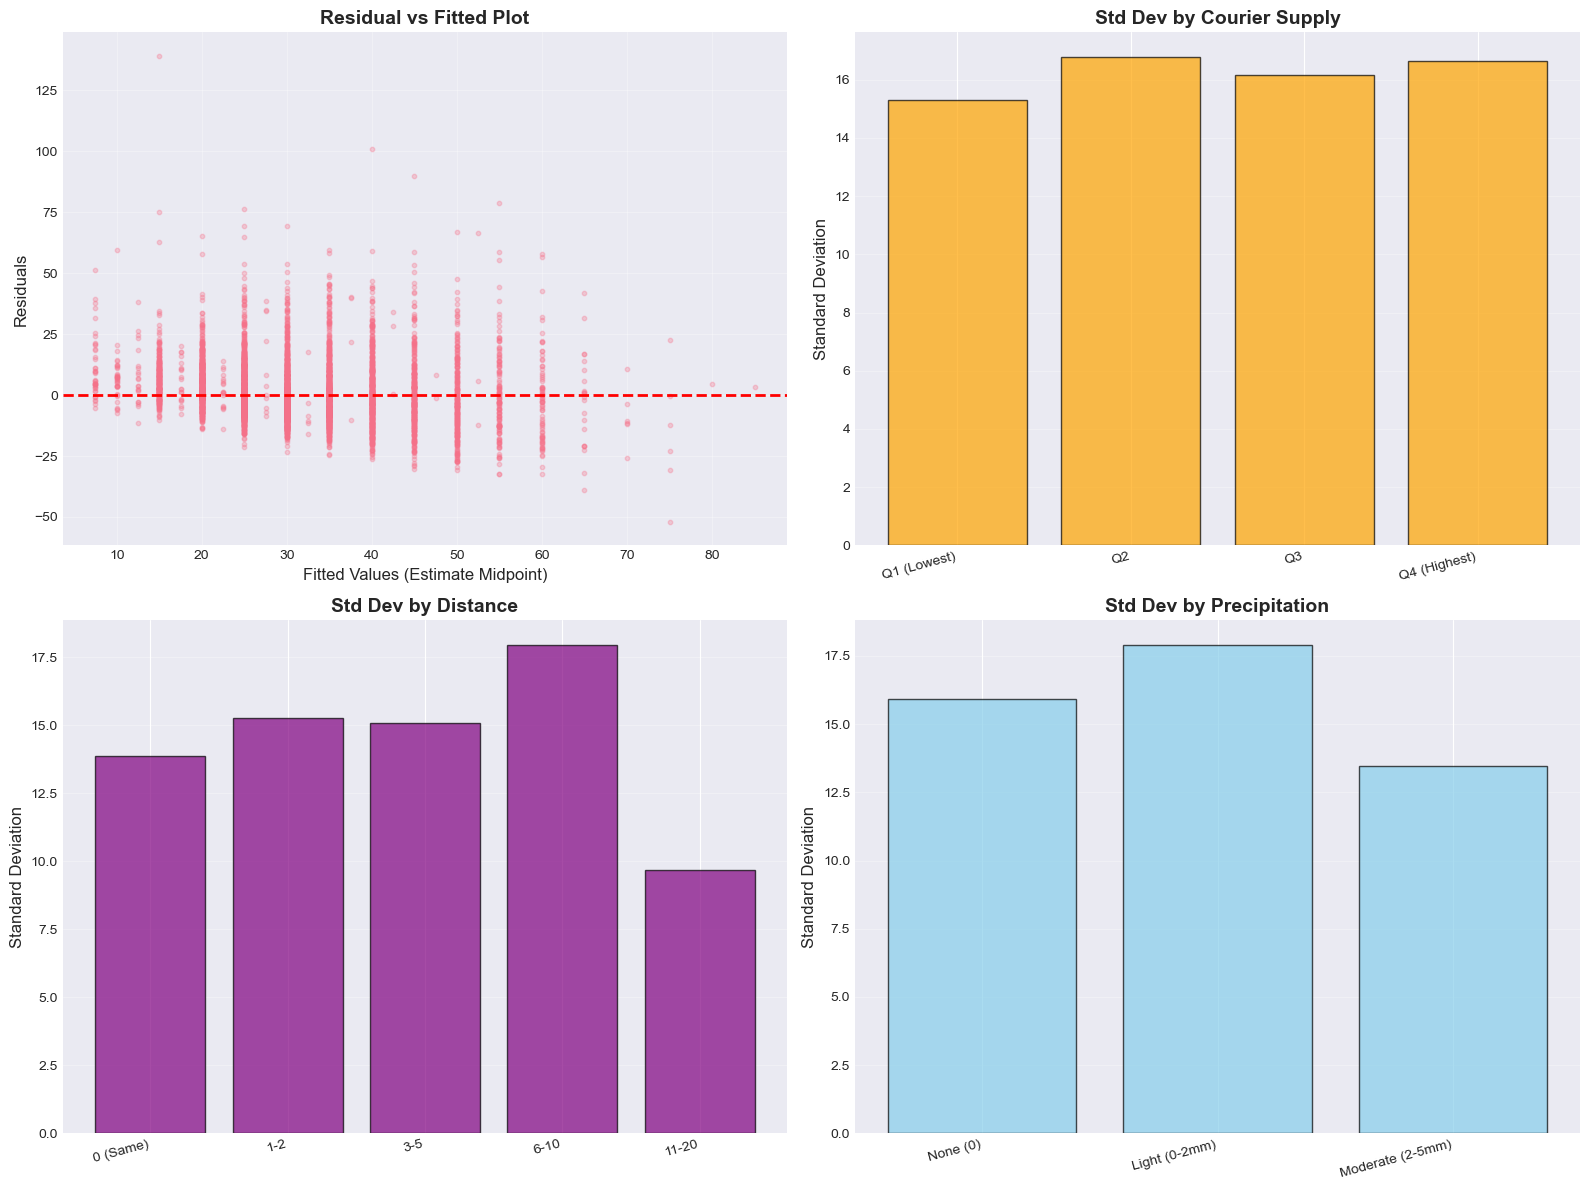

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residual vs fitted (using estimate midpoint as proxy)
sample = df.sample(n=min(5000, len(df)), random_state=42)
axes[0, 0].scatter(sample['estimate_midpoint'], sample['residual'], alpha=0.3, s=10)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values (Estimate Midpoint)', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].set_title('Residual vs Fitted Plot', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Variance by supply
axes[0, 1].bar(range(len(supply_variance)), supply_variance.values, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xticks(range(len(supply_variance)))
axes[0, 1].set_xticklabels(supply_variance.index, rotation=15, ha='right')
axes[0, 1].set_ylabel('Standard Deviation', fontsize=12)
axes[0, 1].set_title('Std Dev by Courier Supply', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Variance by distance
if 'distance_bucket' in df.columns:
    axes[1, 0].bar(range(len(distance_variance)), distance_variance.values, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].set_xticks(range(len(distance_variance)))
    axes[1, 0].set_xticklabels(distance_variance.index, rotation=15, ha='right')
    axes[1, 0].set_ylabel('Standard Deviation', fontsize=12)
    axes[1, 0].set_title('Std Dev by Distance', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# Variance by precipitation
axes[1, 1].bar(range(len(precip_variance)), precip_variance.values, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 1].set_xticks(range(len(precip_variance)))
axes[1, 1].set_xticklabels(precip_variance.index, rotation=15, ha='right')
axes[1, 1].set_ylabel('Standard Deviation', fontsize=12)
axes[1, 1].set_title('Std Dev by Precipitation', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
save_figure('11_heteroscedasticity_analysis.png')
plt.show()

### Interpretation: Section 10

**Key Findings:**
1. **Heteroscedasticity confirmed**: Variance changes with predictors
2. **Stress amplification**: Low supply + bad weather = highest variance
3. **Distance effect**: Longer deliveries have more variable times
4. **Residual patterns**: Non-constant variance visible in residual plot

**Modeling Implications:**
- **Quantile regression** or **distributional models** are essential
- Standard OLS/MSE models will be suboptimal
- **Separate models for mean and variance** recommended
- Consider **weighted regression** or **heteroscedastic neural networks**
- **Prediction intervals** must adapt to conditions
- **Risk-sensitive loss functions** for critical high-variance scenarios

## Section 12: Comprehensive Feature Correlation & Dynamic Importance Analysis

**Goal**: 
- Analyze correlations between ALL features (original + engineered)
- Identify most important features dynamically using multiple methods
- Provide data-driven recommendations for modeling

**Analysis Components**:
1. Feature Preparation & Cleaning
2. Comprehensive Feature Correlation Matrix
3. Target Variable Correlation Analysis
4. Random Forest Feature Importance
5. Permutation Importance
6. Feature Interaction Detection
7. Multicollinearity Assessment
8. Final Modeling Recommendations

### 12.1 Feature Preparation & Cleaning

In [51]:
print("="*80)
print("FEATURE PREPARATION & CLEANING")
print("="*80)

# Define all potential features (original + engineered)
all_potential_features = [
    # Engineered features
    'h3_distance_km', 
    'h3_grid_distance',
    'venue_friction_score',
    'distance_x_weather',
    # Distance/Location features
    'estimated_delivery_time_lower_minutes',
    'estimated_delivery_time_upper_minutes',
    'estimate_midpoint',
    'estimate_width',
    'expected_time_of_delivery',
    # Environmental features
    'courier_supply_index',
    'precipitation',
    # Order features
    'item_count',
    # Time features
    'hour',
    'day_of_week',
    'is_weekend',
    # Categorical features
    'cross_zone_delivery',
    'within_estimate',
    # Zone features (if available)
    'venue_zone',
    'customer_zone'
]

# Check which features exist in the dataset
available_features = [f for f in all_potential_features if f in df.columns]
missing_features = [f for f in all_potential_features if f not in df.columns]

print(f"\n✓ Available features: {len(available_features)}/{len(all_potential_features)}")
if missing_features:
    print(f"⚠️  Missing features ({len(missing_features)}): {', '.join(missing_features)}")

# Separate numeric and categorical features
numeric_features = []
categorical_features = []
boolean_features = []

for col in available_features:
    if df[col].dtype in ['float64', 'int64', 'Int64']:
        numeric_features.append(col)
    elif df[col].dtype == 'bool':
        boolean_features.append(col)
    else:
        categorical_features.append(col)

print(f"\n📊 Feature Types:")
print(f"   • Numeric: {len(numeric_features)}")
print(f"   • Boolean: {len(boolean_features)}")
print(f"   • Categorical: {len(categorical_features)}")

# Create analysis dataframe with numeric features + target
analysis_columns = numeric_features + ['actual_delivery_time_minutes']
df_analysis = df[analysis_columns].copy()

# Convert boolean features to numeric (0/1)
for bool_col in boolean_features:
    df_analysis[bool_col] = df[bool_col].astype(int)
    numeric_features.append(bool_col)

# Encode categorical features if present
from sklearn.preprocessing import LabelEncoder

if 'order_category' in df.columns and 'order_category' not in df_analysis.columns:
    le_cat = LabelEncoder()
    df_analysis['order_category_encoded'] = le_cat.fit_transform(df['order_category'].astype(str))
    numeric_features.append('order_category_encoded')
    print(f"   • Encoded order_category: {len(le_cat.classes_)} categories")

# Encode zone features if available
for zone_col in ['venue_zone', 'customer_zone']:
    if zone_col in df.columns and zone_col not in df_analysis.columns:
        le_zone = LabelEncoder()
        df_analysis[f'{zone_col}_encoded'] = le_zone.fit_transform(df[zone_col].astype(str))
        numeric_features.append(f'{zone_col}_encoded')
        print(f"   • Encoded {zone_col}: {len(le_zone.classes_)} categories")

# Handle missing values
print(f"\n📋 Missing Value Summary:")
missing_summary = df_analysis[numeric_features].isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print("   Features with missing values:")
    for feat, count in missing_summary.items():
        pct = (count / len(df_analysis)) * 100
        print(f"   • {feat}: {count:,} ({pct:.2f}%)")
    
    # Fill missing values with median
    for col in missing_summary.index:
        median_val = df_analysis[col].median()
        df_analysis[col] = df_analysis[col].fillna(median_val)
    print(f"\n   ✓ Filled all missing values with feature medians")
else:
    print("   ✓ No missing values detected")

# Remove any remaining NaNs
initial_rows = len(df_analysis)
df_analysis = df_analysis.dropna()
rows_dropped = initial_rows - len(df_analysis)

if rows_dropped > 0:
    print(f"\n   ⚠️ Dropped {rows_dropped:,} rows with remaining NaN values ({rows_dropped/initial_rows*100:.2f}%)")

print(f"\n✅ Analysis Dataset Ready:")
print(f"   • Rows: {len(df_analysis):,}")
print(f"   • Features: {len(numeric_features)}")
print(f"   • Target: actual_delivery_time_minutes")

# Identify engineered vs original features
engineered = [f for f in numeric_features if f in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather']]
original = [f for f in numeric_features if f not in engineered]

print(f"\n🔢 Feature Breakdown:")
print(f"   • Engineered features: {len(engineered)}")
if engineered:
    for feat in engineered:
        print(f"     - {feat}")
print(f"   • Original/derived features: {len(original)}")

FEATURE PREPARATION & CLEANING

✓ Available features: 14/19
⚠️  Missing features (5): expected_time_of_delivery, is_weekend, cross_zone_delivery, venue_zone, customer_zone

📊 Feature Types:
   • Numeric: 12
   • Boolean: 0
   • Categorical: 2
   • Encoded order_category: 2 categories

📋 Missing Value Summary:
   ✓ No missing values detected

✅ Analysis Dataset Ready:
   • Rows: 16,705
   • Features: 13
   • Target: actual_delivery_time_minutes

🔢 Feature Breakdown:
   • Engineered features: 4
     - h3_distance_km
     - h3_grid_distance
     - venue_friction_score
     - distance_x_weather
   • Original/derived features: 9


### 12.2 Comprehensive Feature Correlation Matrix

**What it does:** Calculates Pearson correlation coefficients between all pairs of numeric features to measure linear relationships. Values range from -1 (perfect negative) to +1 (perfect positive correlation).

**Why it's important:** Identifies redundant features (multicollinearity) that provide duplicate information and can hurt model performance. Also reveals which features move together, helping us understand the data structure and make informed feature selection decisions.


COMPREHENSIVE FEATURE CORRELATION MATRIX

✓ Calculated correlations for 13 features

🔍 Highly Correlated Feature Pairs (|r| > 0.7):
                            Feature_1                             Feature_2  Correlation
                       h3_distance_km                      h3_grid_distance        1.000
estimated_delivery_time_lower_minutes                     estimate_midpoint        0.998
estimated_delivery_time_upper_minutes                     estimate_midpoint        0.998
estimated_delivery_time_lower_minutes estimated_delivery_time_upper_minutes        0.990
                   distance_x_weather                         precipitation        0.701

⚠️ Found 5 highly correlated pairs
   → Potential multicollinearity issues
   → Consider removing one feature from each pair or using regularization
✓ Saved figure: comprehensive_feature_correlation_matrix.png


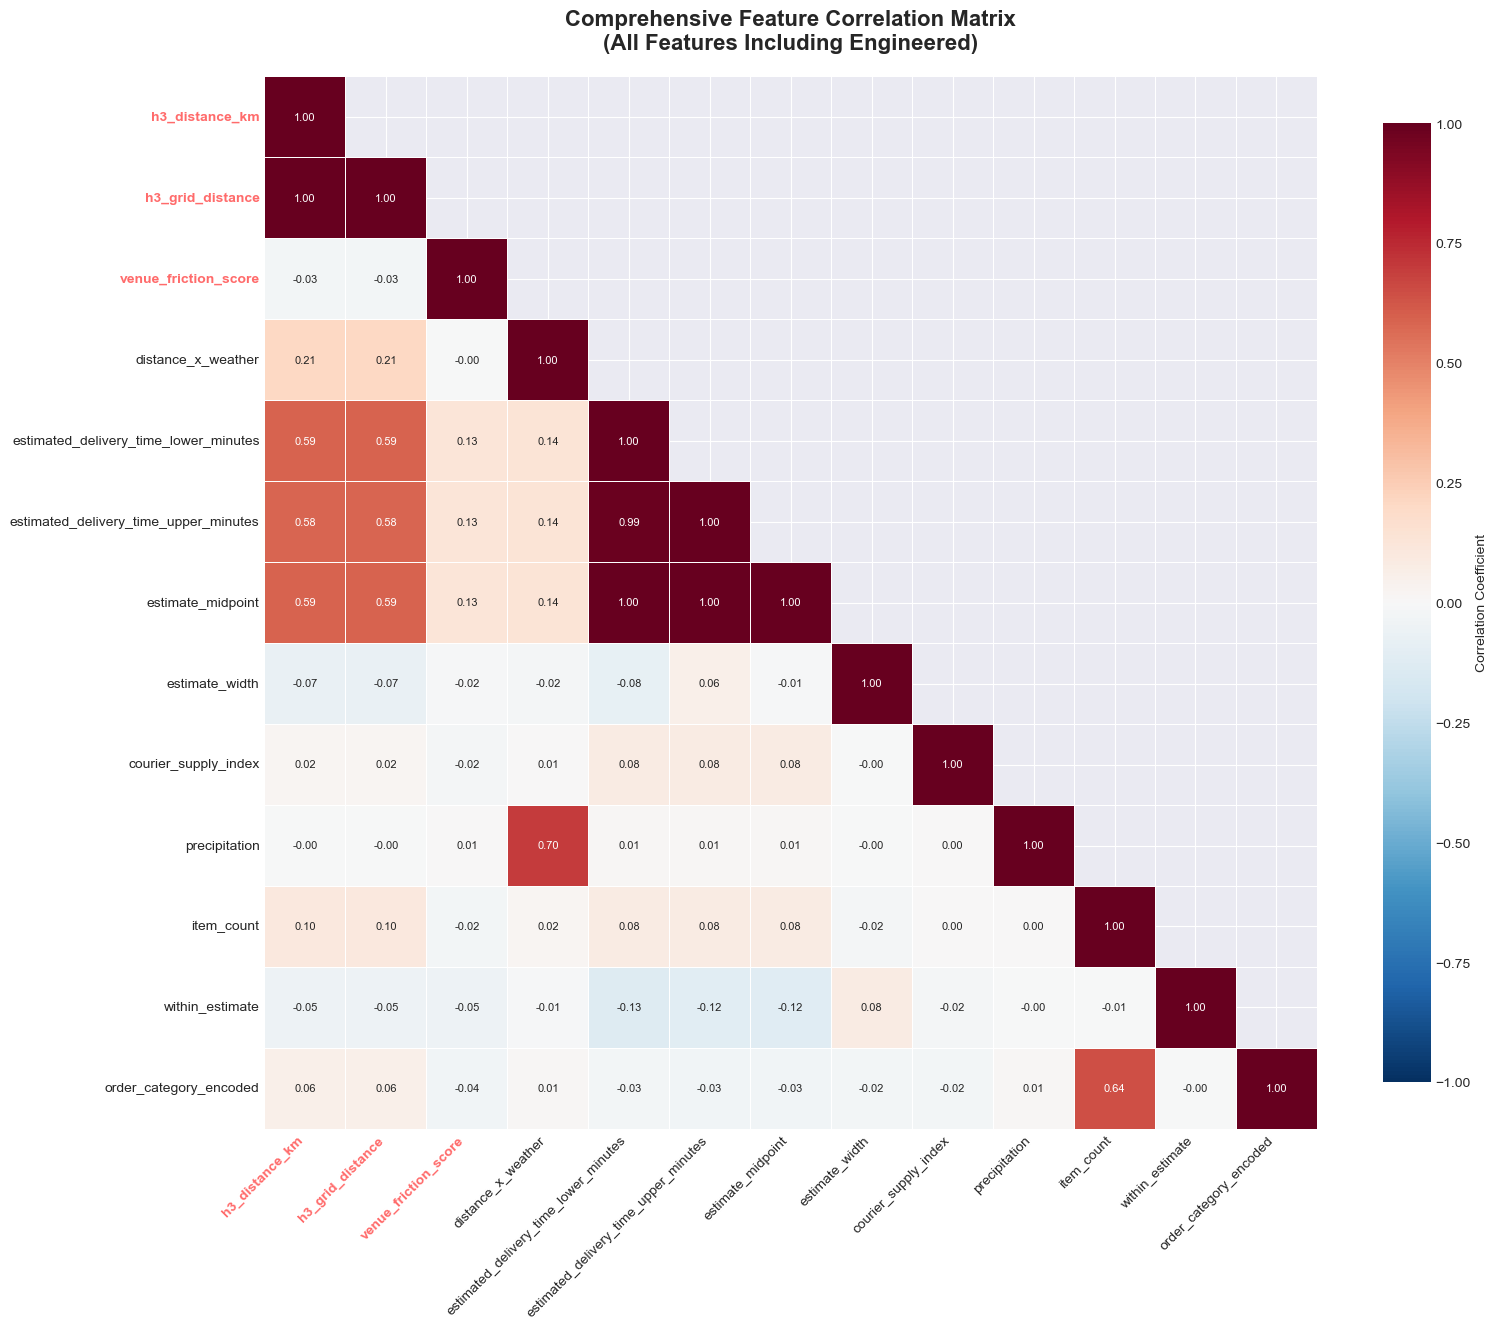


💾 Saved: comprehensive_feature_correlation_matrix.png


In [52]:
print("\n" + "="*80)
print("COMPREHENSIVE FEATURE CORRELATION MATRIX")
print("="*80)

# Calculate correlation matrix for all numeric features
correlation_matrix = df_analysis[numeric_features].corr()

print(f"\n✓ Calculated correlations for {len(numeric_features)} features")

# Find highly correlated feature pairs (excluding diagonal)
print(f"\n🔍 Highly Correlated Feature Pairs (|r| > 0.7):")
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_val,
                'Abs_Correlation': abs(corr_val)
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Abs_Correlation', ascending=False)
    print(high_corr_df[['Feature_1', 'Feature_2', 'Correlation']].to_string(index=False))
    
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated pairs")
    print("   → Potential multicollinearity issues")
    print("   → Consider removing one feature from each pair or using regularization")
else:
    print("   ✓ No severe multicollinearity detected")
    print("   → All features are sufficiently independent")

# Visualize full correlation matrix
fig, ax = plt.subplots(figsize=(16, 14))

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot_kws={"size": 8},
            vmin=-1, vmax=1)

ax.set_title('Comprehensive Feature Correlation Matrix\n(All Features Including Engineered)', 
             fontsize=16, fontweight='bold', pad=20)

# Highlight engineered features
for i, feat in enumerate(correlation_matrix.columns):
    if feat in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score']:
        ax.get_yticklabels()[i].set_color('#FF6B6B')
        ax.get_yticklabels()[i].set_weight('bold')
        ax.get_xticklabels()[i].set_color('#FF6B6B')
        ax.get_xticklabels()[i].set_weight('bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
save_figure('comprehensive_feature_correlation_matrix.png')
plt.show()

print(f"\n💾 Saved: comprehensive_feature_correlation_matrix.png")

### 12.3 Target Correlation Analysis

**What it does:** Measures how strongly each feature correlates with our prediction target (actual delivery time) using both Pearson (linear) and Spearman (monotonic) correlation. Ranks features by their individual predictive value.

**Why it's important:** Quickly identifies which features have the strongest direct relationship with delivery times. High correlation features are likely to be valuable predictors. Differences between Pearson and Spearman reveal non-linear relationships that tree-based models can capture.


TARGET VARIABLE CORRELATION ANALYSIS

Correlations with Delivery Time (sorted by strength):
                              Feature       Type  Pearson  Spearman
                    estimate_midpoint   Original    0.573     0.583
estimated_delivery_time_lower_minutes   Original    0.572     0.583
estimated_delivery_time_upper_minutes   Original    0.572     0.580
                       h3_distance_km Engineered    0.373     0.391
                     h3_grid_distance Engineered    0.373     0.391
                      within_estimate   Original   -0.206    -0.173
                 venue_friction_score Engineered    0.162     0.144
                   distance_x_weather Engineered    0.100     0.082
               order_category_encoded   Original   -0.063    -0.082
                           item_count   Original    0.054     0.094
                 courier_supply_index   Original   -0.035    -0.062
                        precipitation   Original    0.023     0.041
                       

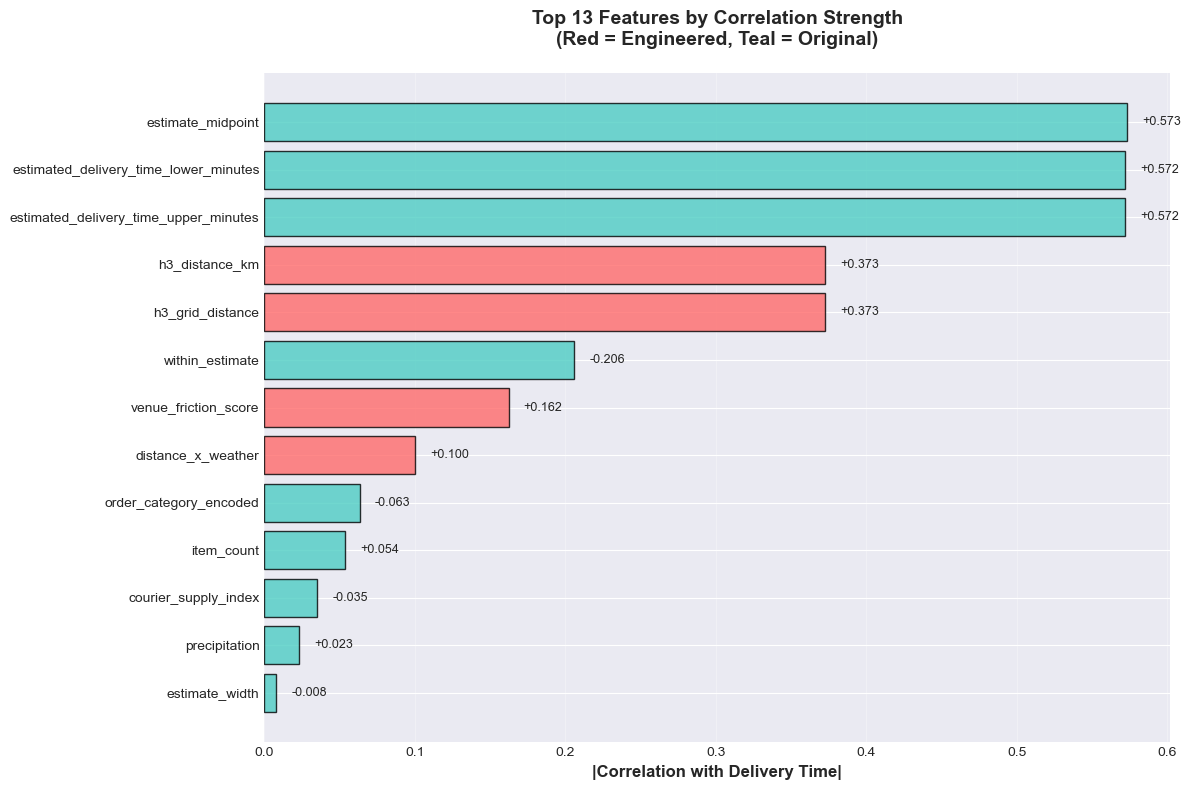


💾 Saved: target_correlation_analysis.png


In [53]:
print("\n" + "="*80)
print("TARGET VARIABLE CORRELATION ANALYSIS")
print("="*80)

# Calculate correlations with target
target_correlations = pd.DataFrame({
    'Feature': numeric_features,
    'Pearson': [df_analysis[feat].corr(df_analysis['actual_delivery_time_minutes']) 
                for feat in numeric_features],
    'Spearman': [df_analysis[feat].corr(df_analysis['actual_delivery_time_minutes'], method='spearman') 
                 for feat in numeric_features],
    'Abs_Pearson': [abs(df_analysis[feat].corr(df_analysis['actual_delivery_time_minutes'])) 
                    for feat in numeric_features]
})

# Mark engineered features
target_correlations['Type'] = target_correlations['Feature'].apply(
    lambda x: 'Engineered' if x in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather'] else 'Original'
)

# Sort by absolute correlation
target_correlations = target_correlations.sort_values('Abs_Pearson', ascending=False)

print(f"\nCorrelations with Delivery Time (sorted by strength):")
print(target_correlations[['Feature', 'Type', 'Pearson', 'Spearman']].to_string(index=False))

# Categorize correlations
strong_pos = target_correlations[target_correlations['Pearson'] > 0.3]
strong_neg = target_correlations[target_correlations['Pearson'] < -0.3]
moderate_pos = target_correlations[(target_correlations['Pearson'] > 0.1) & (target_correlations['Pearson'] <= 0.3)]
moderate_neg = target_correlations[(target_correlations['Pearson'] < -0.1) & (target_correlations['Pearson'] >= -0.3)]
weak = target_correlations[(target_correlations['Pearson'] >= -0.1) & (target_correlations['Pearson'] <= 0.1)]

print(f"\n📊 Correlation Summary:")
print(f"   • Strong positive (r > 0.3): {len(strong_pos)} features")
if len(strong_pos) > 0:
    for _, row in strong_pos.iterrows():
        marker = "🆕" if row['Type'] == 'Engineered' else "📌"
        print(f"      {marker} {row['Feature']}: {row['Pearson']:.3f}")

print(f"   • Strong negative (r < -0.3): {len(strong_neg)} features")
if len(strong_neg) > 0:
    for _, row in strong_neg.iterrows():
        marker = "🆕" if row['Type'] == 'Engineered' else "📌"
        print(f"      {marker} {row['Feature']}: {row['Pearson']:.3f}")

print(f"   • Moderate positive (0.1 < r ≤ 0.3): {len(moderate_pos)} features")
if len(moderate_pos) > 0:
    print(f"      {', '.join(moderate_pos['Feature'].tolist())}")

print(f"   • Moderate negative (-0.3 ≤ r < -0.1): {len(moderate_neg)} features")
if len(moderate_neg) > 0:
    print(f"      {', '.join(moderate_neg['Feature'].tolist())}")

print(f"   • Weak (|r| ≤ 0.1): {len(weak)} features")

# Check for non-linear relationships
print(f"\n🔍 Non-Linear Relationship Detection:")
target_correlations['Diff'] = abs(target_correlations['Spearman'] - target_correlations['Pearson'])
non_linear = target_correlations[target_correlations['Diff'] > 0.05].sort_values('Diff', ascending=False)

if len(non_linear) > 0:
    print(f"   ⚠️ {len(non_linear)} features show potential non-linear relationships:")
    print(non_linear[['Feature', 'Type', 'Pearson', 'Spearman', 'Diff']].to_string(index=False))
    print(f"\n   → Consider polynomial features or tree-based models")
else:
    print("   ✓ No strong evidence of non-linear relationships")
    print("   → Linear models should capture relationships well")

# Visualize top correlations
top_n = min(15, len(target_correlations))
top_features = target_correlations.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#FF6B6B' if t == 'Engineered' else '#4ECDC4' for t in top_features['Type']]
y_pos = np.arange(len(top_features))

bars = ax.barh(y_pos, top_features['Abs_Pearson'], color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('|Correlation with Delivery Time|', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Correlation Strength\n(Red = Engineered, Teal = Original)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add value labels
for i, (val, pearson) in enumerate(zip(top_features['Abs_Pearson'], top_features['Pearson'])):
    sign = '+' if pearson > 0 else ''
    ax.text(val + 0.01, i, f'{sign}{pearson:.3f}', va='center', fontsize=9)

plt.tight_layout()
save_figure('target_correlation_analysis.png')
plt.show()

print(f"\n💾 Saved: target_correlation_analysis.png")

### 12.4 Random Forest Feature Importance

**What it does:** Trains a Random Forest model and measures each feature's importance based on how much it reduces prediction error across all decision trees. Importance is calculated by the average decrease in impurity (variance) when splitting on that feature.

**Why it's important:** Unlike simple correlation, this captures non-linear relationships and feature interactions. It tells us which features the model actually uses most for predictions, not just which correlate with the target. Essential for understanding which features truly drive model performance.


RANDOM FOREST FEATURE IMPORTANCE

📊 Using full dataset: 16,705 rows
🌲 Training Random Forest for feature importance...

✅ Random Forest trained successfully
   • R² Score: 0.4220
   • Features: 13

📊 Feature Importance Rankings:
                              Feature       Type  Importance_Pct  Cumulative
estimated_delivery_time_upper_minutes   Original       4.278e+01       0.428
                    estimate_midpoint   Original       3.307e+01       0.759
                      within_estimate   Original       6.440e+00       0.823
                 courier_supply_index   Original       4.629e+00       0.869
                 venue_friction_score Engineered       4.431e+00       0.914
estimated_delivery_time_lower_minutes   Original       4.150e+00       0.955
                           item_count   Original       1.452e+00       0.970
                     h3_grid_distance Engineered       9.315e-01       0.979
                       h3_distance_km Engineered       8.532e-01       0.987


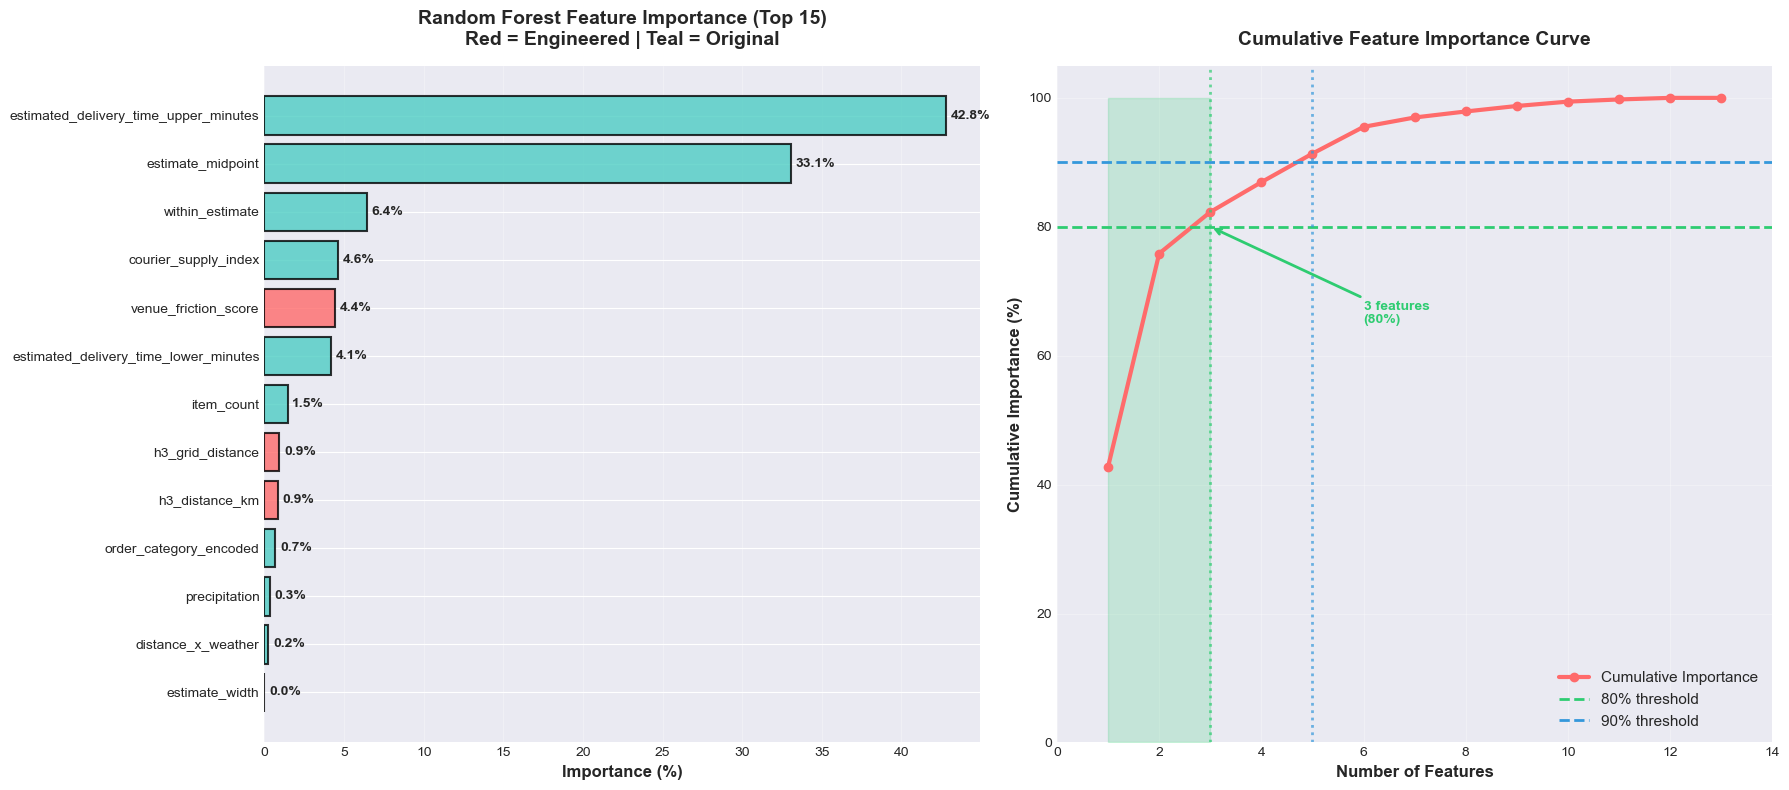


💾 Saved: random_forest_feature_importance.png


In [54]:
print("\n" + "="*80)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*80)

# Prepare data
X = df_analysis[numeric_features].values
y = df_analysis['actual_delivery_time_minutes'].values

# Sample if dataset is large (for computational efficiency)
sample_size = min(50000, len(X))
if len(X) > sample_size:
    print(f"\n📊 Sampling {sample_size:,} rows for computational efficiency...")
    np.random.seed(42)
    sample_idx = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[sample_idx]
    y_sample = y[sample_idx]
else:
    print(f"\n📊 Using full dataset: {len(X):,} rows")
    X_sample = X
    y_sample = y

# Train Random Forest
print("🌲 Training Random Forest for feature importance...")
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf.fit(X_sample, y_sample)

# Calculate feature importance
rf_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': rf.feature_importances_,
    'Type': ['Engineered' if f in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score'] else 'Original' 
             for f in numeric_features]
}).sort_values('Importance', ascending=False)

# Calculate cumulative importance
rf_importance['Cumulative'] = rf_importance['Importance'].cumsum()
rf_importance['Importance_Pct'] = rf_importance['Importance'] * 100

# Model performance
train_r2 = rf.score(X_sample, y_sample)
print(f"\n✅ Random Forest trained successfully")
print(f"   • R² Score: {train_r2:.4f}")
print(f"   • Features: {len(numeric_features)}")

print(f"\n📊 Feature Importance Rankings:")
print(rf_importance[['Feature', 'Type', 'Importance_Pct', 'Cumulative']].to_string(index=False))

# Identify features for 80% importance
n_features_80 = (rf_importance['Cumulative'] <= 0.80).sum() + 1
n_features_90 = (rf_importance['Cumulative'] <= 0.90).sum() + 1
n_features_95 = (rf_importance['Cumulative'] <= 0.95).sum() + 1

print(f"\n🎯 Feature Selection Thresholds:")
print(f"   • Top {n_features_80} features → 80% of importance")
print(f"   • Top {n_features_90} features → 90% of importance")
print(f"   • Top {n_features_95} features → 95% of importance")

top_features_80 = rf_importance.head(n_features_80)['Feature'].tolist()
print(f"\n✨ Critical Features (Top {n_features_80} for 80% importance):")
for i, feat in enumerate(top_features_80, 1):
    imp_val = rf_importance[rf_importance['Feature'] == feat]['Importance_Pct'].iloc[0]
    feat_type = rf_importance[rf_importance['Feature'] == feat]['Type'].iloc[0]
    marker = "🆕" if feat_type == 'Engineered' else "📌"
    print(f"   {i:2d}. {marker} {feat}: {imp_val:.2f}%")

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar plot - Top 15 features
top_15 = rf_importance.head(15)
colors = ['#FF6B6B' if t == 'Engineered' else '#4ECDC4' for t in top_15['Type']]
y_pos = np.arange(len(top_15))

axes[0].barh(y_pos, top_15['Importance_Pct'], color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(top_15['Feature'])
axes[0].set_xlabel('Importance (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Random Forest Feature Importance (Top 15)\nRed = Engineered | Teal = Original', 
                   fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, val in enumerate(top_15['Importance_Pct']):
    axes[0].text(val + 0.3, i, f'{val:.1f}%', va='center', fontsize=10, fontweight='bold')

# Cumulative importance curve
axes[1].plot(range(1, len(rf_importance)+1), rf_importance['Cumulative']*100, 
             marker='o', linewidth=3, markersize=6, color='#FF6B6B', label='Cumulative Importance')
axes[1].axhline(80, color='#2ECC71', linestyle='--', linewidth=2, label='80% threshold')
axes[1].axhline(90, color='#3498DB', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axvline(n_features_80, color='#2ECC71', linestyle=':', linewidth=2, alpha=0.7)
axes[1].axvline(n_features_90, color='#3498DB', linestyle=':', linewidth=2, alpha=0.7)

axes[1].fill_between(range(1, n_features_80+1), 0, 100, alpha=0.2, color='#2ECC71')
axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Feature Importance Curve', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].set_xlim(0, len(rf_importance)+1)
axes[1].set_ylim(0, 105)

# Add annotations
axes[1].annotate(f'{n_features_80} features\n(80%)', 
                 xy=(n_features_80, 80), xytext=(n_features_80+3, 65),
                 fontsize=10, fontweight='bold', color='#2ECC71',
                 arrowprops=dict(arrowstyle='->', color='#2ECC71', lw=2))

plt.tight_layout()
save_figure('random_forest_feature_importance.png')
plt.show()

print(f"\n💾 Saved: random_forest_feature_importance.png")

### 12.5 Permutation Importance

**What it does:** Randomly shuffles each feature's values one at a time and measures how much the model's prediction accuracy degrades. Features causing larger accuracy drops when shuffled are more important.

**Why it's important:** Provides a more reliable measure of true feature importance than built-in RF importance, which can be biased toward high-cardinality features. Permutation importance answers "How much would my predictions suffer if I didn't have this feature?" - the most practical question for feature selection.


PERMUTATION IMPORTANCE ANALYSIS

📊 Using 10,000 samples for permutation importance (computational efficiency)...
🔄 Calculating permutation importance (this may take a moment)...

✅ Permutation importance calculated

📊 Permutation Importance Rankings:
                              Feature       Type  Importance_Mean  Importance_Std
                    estimate_midpoint   Original        1.932e-01       3.525e-03
estimated_delivery_time_upper_minutes   Original        1.442e-01       3.363e-03
                      within_estimate   Original        7.231e-02       2.369e-03
                 courier_supply_index   Original        4.201e-02       1.836e-03
                 venue_friction_score Engineered        3.683e-02       1.433e-03
                           item_count   Original        1.207e-02       8.726e-04
estimated_delivery_time_lower_minutes   Original        8.626e-03       6.496e-04
                     h3_grid_distance Engineered        8.304e-03       5.754e-04
          

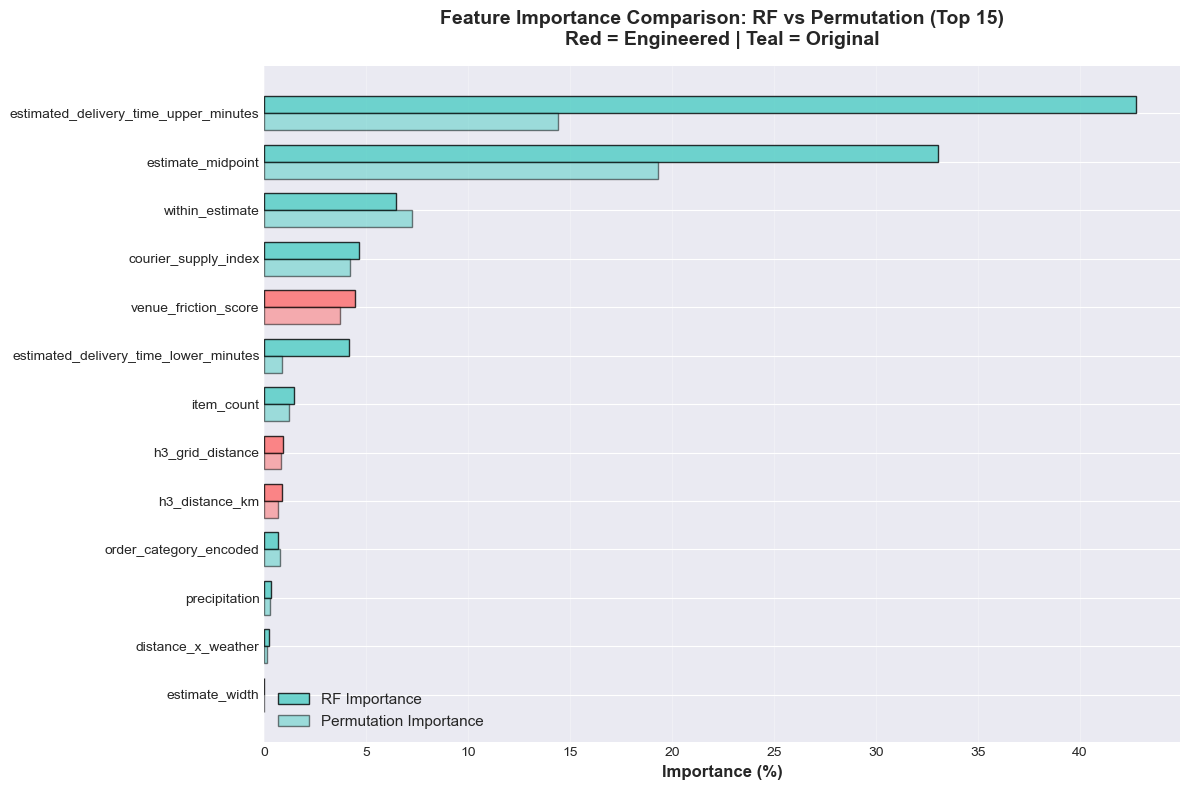


💾 Saved: permutation_importance_comparison.png


In [55]:
print("\n" + "="*80)
print("PERMUTATION IMPORTANCE ANALYSIS")
print("="*80)

from sklearn.inspection import permutation_importance

# Use a smaller sample for permutation importance (computationally expensive)
perm_sample_size = min(10000, len(X_sample))
if len(X_sample) > perm_sample_size:
    print(f"\n📊 Using {perm_sample_size:,} samples for permutation importance (computational efficiency)...")
    perm_idx = np.random.choice(len(X_sample), perm_sample_size, replace=False)
    X_perm = X_sample[perm_idx]
    y_perm = y_sample[perm_idx]
else:
    print(f"\n📊 Using all {len(X_sample):,} samples...")
    X_perm = X_sample
    y_perm = y_sample

print("🔄 Calculating permutation importance (this may take a moment)...")

# Calculate permutation importance
perm_result = permutation_importance(
    rf, X_perm, y_perm,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create dataframe
perm_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance_Mean': perm_result.importances_mean,
    'Importance_Std': perm_result.importances_std,
    'Type': ['Engineered' if f in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather'] else 'Original' 
             for f in numeric_features]
}).sort_values('Importance_Mean', ascending=False)

print(f"\n✅ Permutation importance calculated")
print(f"\n📊 Permutation Importance Rankings:")
print(perm_importance[['Feature', 'Type', 'Importance_Mean', 'Importance_Std']].head(15).to_string(index=False))

# Compare with RF importance - fix column naming issue
rf_for_comparison = rf_importance[['Feature', 'Importance', 'Type']].copy()
rf_for_comparison = rf_for_comparison.rename(columns={'Importance': 'RF_Importance'})

comparison_df = rf_for_comparison.merge(
    perm_importance[['Feature', 'Importance_Mean']], 
    on='Feature'
)
comparison_df['Rank_RF'] = comparison_df['RF_Importance'].rank(ascending=False)
comparison_df['Rank_Perm'] = comparison_df['Importance_Mean'].rank(ascending=False)
comparison_df['Rank_Diff'] = abs(comparison_df['Rank_RF'] - comparison_df['Rank_Perm'])

print(f"\n🔍 Agreement Between Methods:")
top_10_rf = set(rf_importance.head(10)['Feature'])
top_10_perm = set(perm_importance.head(10)['Feature'])
agreement = len(top_10_rf & top_10_perm)
print(f"   • Top 10 features agreement: {agreement}/10 ({agreement*10}%)")
print(f"   • Common features: {', '.join(sorted(top_10_rf & top_10_perm))}")

if len(top_10_rf - top_10_perm) > 0:
    print(f"   • Only in RF top 10: {', '.join(sorted(top_10_rf - top_10_perm))}")
if len(top_10_perm - top_10_rf) > 0:
    print(f"   • Only in Perm top 10: {', '.join(sorted(top_10_perm - top_10_rf))}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 8))

top_15_comparison = comparison_df.sort_values('RF_Importance', ascending=False).head(15)
x = np.arange(len(top_15_comparison))
width = 0.35

colors_rf = ['#FF6B6B' if t == 'Engineered' else '#4ECDC4' for t in top_15_comparison['Type']]
colors_perm = ['#FF6B6B' if t == 'Engineered' else '#4ECDC4' for t in top_15_comparison['Type']]

bars1 = ax.barh(x - width/2, top_15_comparison['RF_Importance']*100, width, 
                label='RF Importance', color=colors_rf, alpha=0.8, edgecolor='black')
bars2 = ax.barh(x + width/2, top_15_comparison['Importance_Mean']*100, width, 
                label='Permutation Importance', color=colors_perm, alpha=0.5, edgecolor='black')

ax.set_yticks(x)
ax.set_yticklabels(top_15_comparison['Feature'])
ax.set_xlabel('Importance (%)', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance Comparison: RF vs Permutation (Top 15)\nRed = Engineered | Teal = Original', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
save_figure('permutation_importance_comparison.png')
plt.show()

print(f"\n💾 Saved: permutation_importance_comparison.png")

### 12.6 Feature Interaction Detection

**What it does:** Creates and tests interaction features (products of two features) to see if they have stronger correlation with the target than individual features alone. Measures the "lift" or improvement in predictive power.

**Why it's important:** Real-world relationships often aren't additive - e.g., the effect of distance on delivery time may amplify in bad weather. Discovering strong interactions guides us to engineer new features that capture these multiplicative effects, significantly improving model accuracy.


FEATURE INTERACTION DETECTION

📊 Testing 3 key interactions...

🔍 Interaction Analysis Results:
       Interaction  Feat1_Corr  Feat2_Corr  Interaction_Corr  Improvement Recommended
 Distance × Supply       0.373       0.035             0.362       -0.011          No
  Supply × Weather       0.035       0.023             0.021       -0.015          No
Distance × Weather       0.373       0.023             0.100       -0.273          No

💡 Interaction Recommendations:
   • No strong interactions found (improvement < 0.03)

   ℹ️ Manual interaction terms show minimal improvement
   → Tree-based models (Random Forest, LightGBM) automatically capture interactions
   → Focus on feature quality rather than manual interaction engineering
✓ Saved figure: feature_interaction_analysis.png


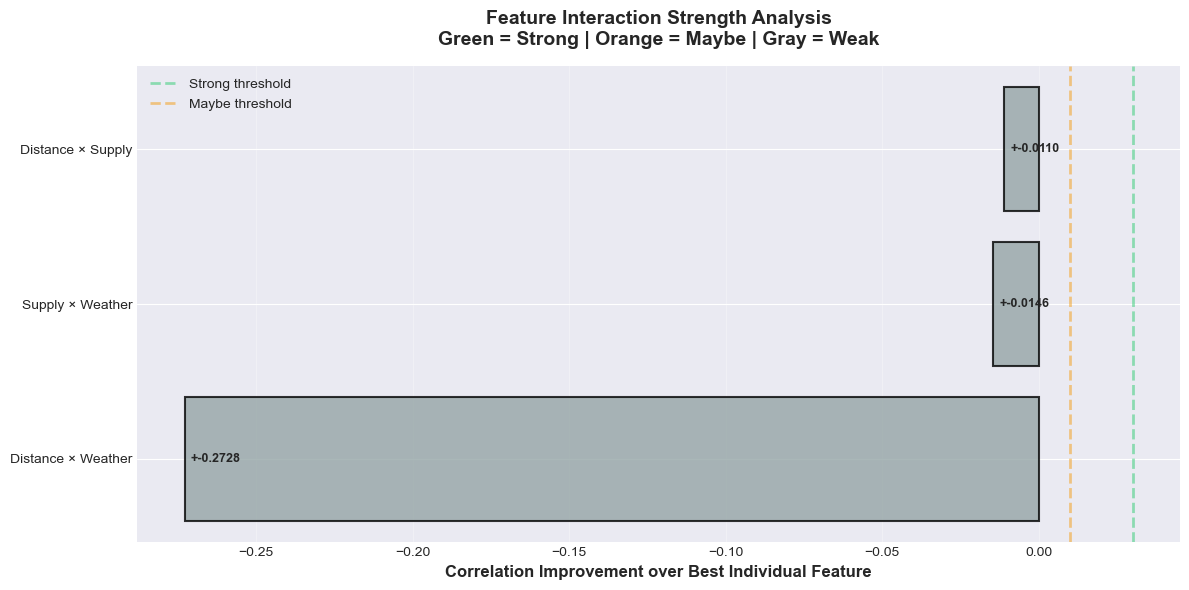


💾 Saved: feature_interaction_analysis.png


In [56]:
print("\n" + "="*80)
print("FEATURE INTERACTION DETECTION")
print("="*80)

# Define key interactions to test
interactions_to_test = []

# Only test if both features exist
if 'courier_supply_index' in numeric_features and 'precipitation' in numeric_features:
    interactions_to_test.append(('courier_supply_index', 'precipitation', 'Supply × Weather'))
    
if 'h3_distance_km' in numeric_features and 'precipitation' in numeric_features:
    interactions_to_test.append(('h3_distance_km', 'precipitation', 'Distance × Weather'))
elif 'h3_grid_distance' in numeric_features and 'precipitation' in numeric_features:
    interactions_to_test.append(('h3_grid_distance', 'precipitation', 'Distance × Weather'))
    
if 'courier_supply_index' in numeric_features and 'hour' in numeric_features:
    interactions_to_test.append(('courier_supply_index', 'hour', 'Supply × Time'))
    
if 'h3_distance_km' in numeric_features and 'hour' in numeric_features:
    interactions_to_test.append(('h3_distance_km', 'hour', 'Distance × Time'))
elif 'h3_grid_distance' in numeric_features and 'hour' in numeric_features:
    interactions_to_test.append(('h3_grid_distance', 'hour', 'Distance × Time'))

if 'item_count' in numeric_features and 'hour' in numeric_features:
    interactions_to_test.append(('item_count', 'hour', 'Items × Time'))
    
if 'h3_distance_km' in numeric_features and 'courier_supply_index' in numeric_features:
    interactions_to_test.append(('h3_distance_km', 'courier_supply_index', 'Distance × Supply'))
elif 'h3_grid_distance' in numeric_features and 'courier_supply_index' in numeric_features:
    interactions_to_test.append(('h3_grid_distance', 'courier_supply_index', 'Distance × Supply'))

if len(interactions_to_test) == 0:
    print("\n⚠️ Insufficient features available for interaction testing")
else:
    print(f"\n📊 Testing {len(interactions_to_test)} key interactions...")
    
    interaction_results = []
    
    for feat1, feat2, name in interactions_to_test:
        # Create interaction term
        df_analysis[f'{feat1}_x_{feat2}'] = df_analysis[feat1] * df_analysis[feat2]
        
        # Calculate correlations
        corr_feat1 = abs(df_analysis[feat1].corr(df_analysis['actual_delivery_time_minutes']))
        corr_feat2 = abs(df_analysis[feat2].corr(df_analysis['actual_delivery_time_minutes']))
        corr_interaction = abs(df_analysis[f'{feat1}_x_{feat2}'].corr(df_analysis['actual_delivery_time_minutes']))
        
        # Calculate improvement over best individual feature
        max_individual = max(corr_feat1, corr_feat2)
        improvement = corr_interaction - max_individual
        improvement_pct = (improvement / max_individual * 100) if max_individual > 0 else 0
        
        interaction_results.append({
            'Interaction': name,
            'Features': f'{feat1} × {feat2}',
            'Feat1_Corr': corr_feat1,
            'Feat2_Corr': corr_feat2,
            'Interaction_Corr': corr_interaction,
            'Improvement': improvement,
            'Improvement_Pct': improvement_pct,
            'Recommended': 'Strong' if improvement > 0.03 else 'Maybe' if improvement > 0.01 else 'No'
        })
    
    interaction_df = pd.DataFrame(interaction_results).sort_values('Improvement', ascending=False)
    
    print(f"\n🔍 Interaction Analysis Results:")
    print(interaction_df[['Interaction', 'Feat1_Corr', 'Feat2_Corr', 
                           'Interaction_Corr', 'Improvement', 'Recommended']].to_string(index=False))
    
    # Recommendations
    print(f"\n💡 Interaction Recommendations:")
    strong_interactions = interaction_df[interaction_df['Recommended'] == 'Strong']
    maybe_interactions = interaction_df[interaction_df['Recommended'] == 'Maybe']
    
    if len(strong_interactions) > 0:
        print(f"   ✅ STRONGLY RECOMMENDED ({len(strong_interactions)}):")
        for _, row in strong_interactions.iterrows():
            print(f"      • {row['Interaction']}: Improvement = +{row['Improvement']:.4f} ({row['Improvement_Pct']:.1f}%)")
            print(f"        → Include this interaction term in modeling")
    else:
        print(f"   • No strong interactions found (improvement < 0.03)")
    
    if len(maybe_interactions) > 0:
        print(f"\n   ⚠️ POTENTIALLY USEFUL ({len(maybe_interactions)}):")
        for _, row in maybe_interactions.iterrows():
            print(f"      • {row['Interaction']}: Improvement = +{row['Improvement']:.4f} ({row['Improvement_Pct']:.1f}%)")
            print(f"        → Test in model validation")
    
    if len(strong_interactions) == 0 and len(maybe_interactions) == 0:
        print(f"\n   ℹ️ Manual interaction terms show minimal improvement")
        print(f"   → Tree-based models (Random Forest, LightGBM) automatically capture interactions")
        print(f"   → Focus on feature quality rather than manual interaction engineering")
    
    # Visualize top interactions
    if len(interaction_df) > 0:
        fig, ax = plt.subplots(figsize=(12, max(6, len(interaction_df) * 0.5)))
        
        colors = ['#2ECC71' if r == 'Strong' else '#F39C12' if r == 'Maybe' else '#95A5A6' 
                  for r in interaction_df['Recommended']]
        
        y_pos = np.arange(len(interaction_df))
        bars = ax.barh(y_pos, interaction_df['Improvement'], color=colors, 
                       edgecolor='black', alpha=0.8, linewidth=1.5)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(interaction_df['Interaction'])
        ax.set_xlabel('Correlation Improvement over Best Individual Feature', fontsize=12, fontweight='bold')
        ax.set_title('Feature Interaction Strength Analysis\nGreen = Strong | Orange = Maybe | Gray = Weak', 
                     fontsize=14, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3, axis='x')
        ax.axvline(0.03, color='#2ECC71', linestyle='--', linewidth=2, alpha=0.5, label='Strong threshold')
        ax.axvline(0.01, color='#F39C12', linestyle='--', linewidth=2, alpha=0.5, label='Maybe threshold')
        ax.invert_yaxis()
        ax.legend()
        
        # Add value labels
        for i, val in enumerate(interaction_df['Improvement']):
            ax.text(val + 0.002, i, f'+{val:.4f}', va='center', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        save_figure('feature_interaction_analysis.png')
        plt.show()
        
        print(f"\n💾 Saved: feature_interaction_analysis.png")

### 12.7 Final Data-Driven Modeling Recommendations

Comprehensive summary of feature analysis and actionable recommendations for modeling.

In [ ]:
print("\n" + "="*80)
print("FINAL DATA-DRIVEN MODELING RECOMMENDATIONS")
print("="*80)

# Compile all analysis results
print("\n" + "="*80)
print("COMPREHENSIVE FEATURE ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 Dataset Summary:")
print(f"   • Total samples: {len(df_analysis):,}")
print(f"   • Total features analyzed: {len(numeric_features)}")
print(f"   • Engineered features: {len([f for f in numeric_features if f in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather']])}")
print(f"   • Original features: {len([f for f in numeric_features if f not in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather']])}")

# Top features by different methods
print(f"\n" + "="*60)
print("TOP FEATURES BY ANALYSIS METHOD")
print("="*60)

# Correlation
top_5_corr = target_correlations.head(5)
print(f"\n1️⃣ TOP 5 BY CORRELATION:")
for i, row in enumerate(top_5_corr.itertuples(), 1):
    marker = "🆕" if row.Type == 'Engineered' else "📌"
    print(f"   {i}. {marker} {row.Feature}: r = {row.Pearson:.4f}")

# RF Importance
top_5_rf = rf_importance.head(5)
print(f"\n2️⃣ TOP 5 BY RANDOM FOREST IMPORTANCE:")
for i, row in enumerate(top_5_rf.itertuples(), 1):
    marker = "🆕" if row.Type == 'Engineered' else "📌"
    print(f"   {i}. {marker} {row.Feature}: {row.Importance_Pct:.2f}%")

# Permutation Importance
top_5_perm = perm_importance.head(5)
print(f"\n3️⃣ TOP 5 BY PERMUTATION IMPORTANCE:")
for i, row in enumerate(top_5_perm.itertuples(), 1):
    marker = "🆕" if row.Type == 'Engineered' else "📌"
    print(f"   {i}. {marker} {row.Feature}: {row.Importance_Mean:.4f}")

# Consensus features (appearing in top 10 of all methods)
top_10_corr_set = set(target_correlations.head(10)['Feature'])
top_10_rf_set = set(rf_importance.head(10)['Feature'])
top_10_perm_set = set(perm_importance.head(10)['Feature'])

consensus_features = top_10_corr_set & top_10_rf_set & top_10_perm_set
strong_features = (top_10_corr_set & top_10_rf_set) | (top_10_corr_set & top_10_perm_set) | (top_10_rf_set & top_10_perm_set)

print(f"\n" + "="*60)
print("CONSENSUS ACROSS METHODS")
print("="*60)

if consensus_features:
    print(f"\n✅ CRITICAL FEATURES (in top 10 of ALL 3 methods) - {len(consensus_features)} features:")
    for feat in sorted(consensus_features):
        feat_type = "🆕 Engineered" if feat in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather'] else "📌 Original"
        corr_val = target_correlations[target_correlations['Feature'] == feat]['Pearson'].iloc[0]
        rf_val = rf_importance[rf_importance['Feature'] == feat]['Importance_Pct'].iloc[0]
        print(f"   • {feat_type}: {feat}")
        print(f"     └─ Correlation: {corr_val:.4f} | RF Importance: {rf_val:.2f}%")
else:
    print(f"\n⚠️ No features in top 10 of all 3 methods")

if strong_features - consensus_features:
    print(f"\n⭐ IMPORTANT FEATURES (in top 10 of 2/3 methods) - {len(strong_features - consensus_features)} features:")
    for feat in sorted(strong_features - consensus_features):
        feat_type = "🆕 Engineered" if feat in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather'] else "📌 Original"
        print(f"   • {feat_type}: {feat}")

# Feature importance for 80% threshold
print(f"\n" + "="*60)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*60)

print(f"\n📈 For 80% Model Performance:")
print(f"   Use top {n_features_80} features from Random Forest ranking:")
top_features_for_modeling = rf_importance.head(n_features_80)
for i, row in enumerate(top_features_for_modeling.itertuples(), 1):
    marker = "🆕" if row.Type == 'Engineered' else "📌"
    print(f"   {i:2d}. {marker} {row.Feature} ({row.Importance_Pct:.2f}%)")

# Model recommendations
print(f"\n" + "="*60)
print("MODEL ALGORITHM RECOMMENDATIONS")
print("="*60)

print(f"\n🎯 RECOMMENDED MODELS:")

# Check for multicollinearity
has_multicollinearity = len(high_corr_pairs) > 0 if 'high_corr_pairs' in locals() else False

print(f"\n1️⃣ LightGBM (HIGHLY RECOMMENDED)")
print(f"   ✓ Handles all feature types automatically")
print(f"   ✓ Captures non-linear relationships and interactions")
print(f"   ✓ Fast training and prediction")
print(f"   ✓ Robust to multicollinearity")
print(f"   ✓ Built-in feature importance")

print(f"\n2️⃣ Random Forest")
print(f"   ✓ Robust and reliable")
print(f"   ✓ Handles non-linear relationships well")
print(f"   ✓ Good for feature importance analysis")
print(f"   ✓ Less prone to overfitting than single trees")

print(f"\n3️⃣ Ridge Regression (with feature selection)")
print(f"   ✓ Good baseline if relationships are mostly linear")
if has_multicollinearity:
    print(f"   ✓ Regularization handles multicollinearity")
print(f"   ⚠️ Requires feature scaling")
print(f"   ⚠️ May miss complex interactions")

# Interaction recommendations
if 'strong_interactions' in locals() and len(strong_interactions) > 0:
    print(f"\n" + "="*60)
    print("FEATURE ENGINEERING RECOMMENDATIONS")
    print("="*60)
    print(f"\n✨ RECOMMENDED INTERACTION TERMS:")
    for _, row in strong_interactions.iterrows():
        print(f"   • Add: {row['Features']}")
        print(f"     └─ Improvement: +{row['Improvement']:.4f} correlation")

# Multicollinearity warning
if has_multicollinearity:
    print(f"\n" + "="*60)
    print("MULTICOLLINEARITY HANDLING")
    print("="*60)
    print(f"\n⚠️ Detected {len(high_corr_pairs)} highly correlated feature pairs")
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"   1. Use tree-based models (LightGBM/RF) - they handle multicollinearity well")
    print(f"   2. For linear models: Use Ridge/Lasso regularization")
    print(f"   3. Or remove one feature from each highly correlated pair")

# Value of engineered features
engineered_in_top = [f for f in rf_importance.head(n_features_80)['Feature'] 
                     if f in ['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather']]

print(f"\n" + "="*60)
print("ENGINEERED FEATURE VALUE ASSESSMENT")
print("="*60)

if engineered_in_top:
    print(f"\n✅ ENGINEERED FEATURES ARE VALUABLE!")
    print(f"   {len(engineered_in_top)}/{len(['h3_distance_km', 'h3_grid_distance', 'venue_friction_score', 'distance_x_weather'])} engineered features in top {n_features_80} (80% importance)")
    print(f"\n   Features in critical set:")
    for feat in engineered_in_top:
        rank = rf_importance[rf_importance['Feature'] == feat].index[0] + 1
        imp = rf_importance[rf_importance['Feature'] == feat]['Importance_Pct'].iloc[0]
        print(f"   • {feat}: Rank #{rank} ({imp:.2f}% importance)")
    print(f"\n   → KEEP all engineered features in final model")
else:
    print(f"\n⚠️ Engineered features not in top {n_features_80}")
    print(f"   → Evaluate if feature engineering strategy needs adjustment")

